# CIC-Darknet 2020 Verisinin İncelenmesi ve Sınıflandırma Çalışması

---

## 0- Importlar

In [1]:
import pandas as pd
pd.options.display.min_rows = 100
pd.options.display.max_columns = 100

import time
import matplotlib.pyplot as plt
import pyarrow
import os

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from skopt import BayesSearchCV

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

---

## 1- Giriş

**Amaç:** Bu sunumun amacı, CIC-Darknet 2020 verisini inceleyip alanındaki önemini, özelliklerini ve potansiyel uygulama alanlarını anlamaktır.

---

## 2- Arka Plan

Siber güvenlik alanında verinin önemi azımsanamayacak kadar büyüktür. Temel amaçlarından biri verilerimizin güvenliğini sağlamak olan bu alanda çeşitli çalışma ve geliştirmelere malzeme olan birçok veri seti vardır. 

CIC-Darknet 2020 verisi, Darknet gibi siber güvenlik alanında önemli bir konseptle ilgili bir veri seti olması, sınıflandırma çalışmalarına uygun olması ve (her ne kadar bu sunumda ham haliyle çalışmaya başlıyor olsak da) internette temizlenip parquet dosyasına çevrilmiş haliyle bulunması sebebiyle önemli bir veri setidir. 

---

## 3- Verinin İncelenmesi

### 3.2- İncelemeye Giriş
Verinin genel incelenmesi öncesi ilgilendiği konsept Darknet hakkında bilgi sahibi olalım. Darknet, diğer bilgisayarlarla etkileşime gireceği beklenmeyen, internetin kullanılmayan adres alanıdır. Bu alandan gelen herhangi bir iletişim, pasif dinleme doğasından ötürü kuşkuyla karşılanır. Gelen paketler kabul edilir ancak giden paketler için destek söz konusu değildir. 

Darknet;
- Ağ teleskobu: Kişinin Dünya üzerinde meydana gelen farklı büyük ölçekli olayları gözlemlemesine olanak tanıyan bir internet sistemi
- Sinkhole: Tüm alan adları için yönlendirilemez adresler dağıtmaya ayarlı bir DNS sunucusu
- Blackhole: Bir internet servis sağlayıcısının kullanılmayan, yönlendirilebilir adres ağı

olarak da bilinir.

Darknet trafiği sınıflandırması, gerçek zamanlı uygulamaları kategorize etmek için oldukça önemlidir. Darknet analizi, kötü amaçlı yazılımların saldırı öncesinden izlenmesine ve salgın sonrası zararlı faaliyetlerin tespit edilmesine yardımcı olur.

Bu veri, akademik bir ağ trafiği sınıflandırma verisidir. CIC (Canadian Institute for Cybersecurity, Kanada Siber Güvenlik Enstitüsü) tarafından yayınlanmış olup kendinden önceki iki CIC veri yayınının ([ISCXTor2016](https://www.unb.ca/cic/datasets/tor.html) ve [ISCXVPN2016](https://www.unb.ca/cic/datasets/vpn.html)) birleşiminden oluşmaktadır. 

Bu veri setinde ilk katmanda zararsız ve Darknet trafiği üretmek için iki katmanlı bir yaklaşım uygulanmıştır. Darknet trafiği, ikinci katmanda oluşturulmuş olan Audio-Stream, Browsing, Chat, Email, P2P, Transfer, Video-Stream ve VOIP'den (Voice Over Internet Protocol) oluşur. Tablo 1'de Darknet trafiğinin kategorileri ve kategorilerin oluşturulmasında yararlanılan uygulamalar görülebilir.

##### **Tablo 1: Darknet Ağ Trafiği Detayları**<sup>[1]</sup>
| Kategori     | Kullanılan Uygulamalar                                                                                |
|--------------|-------------------------------------------------------------------------------------------------------|
| Audio-Stream | Vimeo ve YouTube                                                                                      | 
| Browsing     | Firefox ve Chrome                                                                                     | 
| Chat         | ICQ, AIM, Skype, Facebook ve Hangouts                                                                 |
| Email        | SMTPS, POP3S ve IMAPS                                                                                 | 
| P2P          | uTorrent ve Transmission (BitTorrent)                                                                 | 
| Transfer     | Skype, Filezilla ve harici bir hizmet kullanarak SSH üzerinden FTP (SFTP) ve SSL üzerinden FTP (FTPS) | 
| Video-Stream | Vimeo ve YouTube                                                                                      | 
| VOIP         | Facebook, Skype ve Hangouts sesli aramaları                                                           | 

---

### 3.2- Verinin Detayları
Yukarıda açıklanan çift katmanlı yaklaşım ve kategorilerin dağılımı Görsel 1'de görülebilir.<sup>[2]</sup>

![title](darknet.jpg)

İlk katmanda zararsız ve Darknet trafiği görülürken ikinci katmanda ise Darknet trafiğini oluşturan özelliklerin dağılımı görülmektedir.

Verinin ham halinde 85 sütun (özellik), 141.530 satır bulunup özelliklerin açıklaması şu şekildedir:
- **Flow ID:** Ağ trafiğinin her bir akışı için benzersiz kimlik.
- **Src IP:** Ağ trafiğinin kaynak IP adresi.
- **Src Port:** Ağ trafiğinin kaynak port numarası.
- **Dst IP:** Hedefin IP adresi.
- **Dst Port:** Hedefin port numarası.
- **Protocol:** Ağ trafiği için kullanılan protokol (örneğin, TCP, UDP).
- **Timestamp:** Ağ trafiğinin gerçekleştiği zaman damgası.
- **Flow Duration:** Akışın süresi, yani akışın ilk ve son paketi arasındaki zaman farkı.
- **Total Fwd Packet:** İleri yönde gönderilen (forward) toplam paket sayısı.
- **Total Bwd packets:** Geri yönde gönderilen (backward) toplam paket sayısı.
- **Total Length of Fwd Packet:** İleri yönde gönderilen paketlerin toplam uzunluğu.
- **Total Length of Bwd Packet:** Geri yönde gönderilen paketlerin toplam uzunluğu.
- **Fwd Packet Length Max:** İleri yönde gönderilen paketlerin maksimum uzunluğu.
- **Fwd Packet Length Min:** İleri yönde gönderilen paketlerin minimum uzunluğu.
- **Fwd Packet Length Mean:** İleri yönde gönderilen paketlerin ortalama uzunluğu.
- **Fwd Packet Length Std:** İleri yönde gönderilen paketlerin uzunluğunun standart sapması.
- **Bwd Packet Length Max:** Geri yönde gönderilen paketlerin maksimum uzunluğu.
- **Bwd Packet Length Min:** Geri yönde gönderilen paketlerin minimum uzunluğu.
- **Bwd Packet Length Mean:** Geri yönde gönderilen paketlerin ortalama uzunluğu.
- **Bwd Packet Length Std:** Geri yönde gönderilen paketlerin uzunluğunun standart sapması.
- **Flow Bytes/s:** Byte cinsinden saniyedeki akış hızı.
- **Flow Packets/s:**  Paket cinsinden saniyedeki akış hızı.
- **Flow IAT Mean:** Akış paketlerinin arasındaki ortalama zaman. (IAT = inter-arrival time)
- **Flow IAT Std:** Akış paketlerinin arasındaki zamanın standart sapması.
- **Flow IAT Max:** Akış paketlerinin arasındaki maksimum zaman.
- **Flow IAT Min:** Akış paketlerinin arasındaki minimum zaman.
- **Fwd IAT Total:** İleri yönde gönderilen paketlerin arasındaki toplam zaman.
- **Fwd IAT Mean:** İleri yönde gönderilen paketlerin arasındaki ortalama zaman.
- **Fwd IAT Std:** İleri yönde gönderilen paketlerin arasındaki zamanın standart sapması.
- **Fwd IAT Max:** İleri yönde gönderilen paketlerin arasındaki maksimum zaman.
- **Fwd IAT Min:** İleri yönde gönderilen paketlerin arasındaki minimum zaman.
- **Bwd IAT Total:** Geri yönde gönderilen paketlerin arasındaki toplam zaman.
- **Bwd IAT Mean:** Geri yönde gönderilen paketlerin arasındaki ortalama zaman.
- **Bwd IAT Std:** Geri yönde gönderilen paketlerin arasındaki zamanın standart sapması.
- **Bwd IAT Max:** Geri yönde gönderilen paketlerin arasındaki maksimum zaman.
- **Bwd IAT Min:** Geri yönde gönderilen paketlerin arasındaki minimum zaman.
- **Fwd PSH Flags:** İleri yönde PUSH bayrağı (verinin olabildiğince çabuk bir şekilde alıcı uygulamaya gönderilmesini belirten bayrak) ayarlanmış paket sayısı.
- **Bwd PSH Flags:** Geri yönde PUSH bayrağı ayarlanmış paket sayısı.
- **Fwd URG Flags:** İleri yönde URGENT bayrağı (verinin acil ilgi beklediğini belirten bayrak) ayarlanmış paket sayısı.
- **Bwd URG Flags:** Geri yönde URGENT bayrağı ayarlanmış paket sayısı.
- **Fwd Header Length:** İleri yönde gönderilen paketlerin toplam başlık uzunluğu.
- **Bwd Header Length:** Geri yönde gönderilen paketlerin toplam başlık uzunluğu.
- **Fwd Packets/s:** İleri yönde saniyedeki paket oranı.
- **Bwd Packets/s:** Geri yönde saniyedeki paket oranı.
- **Packet Length Min:** Paketlerin minimum uzunluğu.
- **Packet Length Max:** Paketlerin maksimum uzunluğu.
- **Packet Length Mean:** Paketlerin ortalama uzunluğu.
- **Packet Length Std:** Paket uzunluğunun standart sapması.
- **Packet Length Variance:** Paket uzunluğunun varyansı.
- **FIN Flag Count:** FIN bayrağı (Finish, TCP bağlantısının sonlandığını belirten bayrak) ayarlanmış paket sayısı.
- **SYN Flag Count:** SYN bayrağı (Synchronize, TCP bağlantısı kurulmasını başlatan bayrak) ayarlanmış paket sayısı.
- **RST Flag Count:** RST bayrağı (Reset, bağlantıyı sıfırlamak için kullanılan bayrak) ayarlanmış paket sayısı.
- **PSH Flag Count:** PSH bayrağı ayarlanmış paket sayısı.
- **ACK Flag Count:** ACK bayrağı (Acknowledgement, alınan veriyi onaylamak için kullanılan bayrak) ayarlanmış paket sayısı.
- **URG Flag Count:** URG bayrağı ayarlanmış paket sayısı.
- **CWE Flag Count:** CWE bayrağı (Congestion Window Reduced, göndericinin bir TCP segmentini ECE bayrağı ayarlanmış olarak aldığını ve iletim hızını buna göre azalttığını bildiren bayrak) ayarlanmış paket sayısı.
- **ECE Flag Count:** ECE bayrağı (Explicit Congestion Notification Echo, ağda bir tıkanıklık yaşandığını göndericiye bildiren bayrak) ayarlanmış paket sayısı.
- **Down/Up Ratio:** Aşağı yönde gönderilen trafiğin yukarıya oranı.
- **Average Packet Size:** Ortalama paket boyutu.
- **Fwd Segment Size Avg:** İleri yönde gönderilen segmentlerin ortalama boyutu.
- **Bwd Segment Size Avg:** Geri yönde gönderilen segmentlerin ortalama boyutu.
- **Fwd Bytes/Bulk Avg:** İleri yönde küme olarak gönderilen ortalama bayt değeri.
- **Fwd Packet/Bulk Avg:** İleri yönde küme olarak gönderilen ortalama paket değeri.
- **Fwd Bulk Rate Avg:** İleri yönde gönderilen kümelerin ortalama oranı.
- **Bwd Bytes/Bulk Avg:** Geri yönde küme olarak gönderilen ortalama bayt değeri.
- **Bwd Packet/Bulk Avg:** Geri yönde küme olarak gönderilen ortalama paket değeri.
- **Bwd Bulk Rate Avg:** Geri yönde gönderilen kümelerin ortalama oranı.
- **Subflow Fwd Packets:** İleri yönde gönderilen alt akış paket sayısı.
- **Subflow Fwd Bytes:** İleri yönde gönderilen alt akış bayt sayısı.
- **Subflow Bwd Packets:** Geri yönde gönderilen alt akış paket sayısı.
- **Subflow Bwd Bytes:** Geri yönde gönderilen alt akış bayt sayısı.
- **FWD Init Win Bytes:** İleri başlangıç penceresi boyutu.
- **Bwd Init Win Bytes:** Geri başlangıç penceresi boyutu.
- **Fwd Act Data Pkts:** İleri yönde asıl veriyi içeren paket sayısı.
- **Fwd Seg Size Min:** Minimum segment boyutu.
- **Active Mean:** Bir akışın aktif olduğu ortalama süre.
- **Active Std:** Bir akışın aktif olduğu sürenin standart sapması.
- **Active Max:** Bir akışın aktif olduğu maksimum süre.
- **Active Min:** Bir akışın aktif olduğu minimum süre.
- **Idle Mean:** Bir akışın boşta olduğu ortalama süre.
- **Idle Std:** Bir akışın boşta olduğu sürenin standart sapması.
- **Idle Max:** Bir akışın boşta olduğu maksimum süre.
- **Idle Min:** Bir akışın boşta olduğu minimum süre.
- **Label:** Trafik türünü gösteren sınıflandırma etiketi (Non-Tor, NonVPN, Tor, VPN).
- **Label.1:** Verinin kategorisi (AUDIO-STREAMING, Browsing, Chat, Email, File-Transfer, File-transfer, P2P, Video-Streaming, Audio-Streaming, Video-streaming, VOIP).


---

## 4- Veri Ön İşleme

Bunun için öncelikle veriyi elde etmemiz gerekiyor.

In [2]:
data = pd.read_csv('DarknetHamVeriSeti.CSV')
df = pd.DataFrame(data)

Şimdi özelliklerin boş olma durumlarını yüzdelik olarak inceleyelim.

In [3]:
(df.isnull().sum().sort_values(ascending=False) / len(df)) * 100

Flow Bytes/s              0.033209
Flow ID                   0.000000
Bwd Bytes/Bulk Avg        0.000000
Fwd Packet/Bulk Avg       0.000000
Fwd Bytes/Bulk Avg        0.000000
Bwd Segment Size Avg      0.000000
Fwd Segment Size Avg      0.000000
Average Packet Size       0.000000
Down/Up Ratio             0.000000
ECE Flag Count            0.000000
CWE Flag Count            0.000000
URG Flag Count            0.000000
ACK Flag Count            0.000000
PSH Flag Count            0.000000
RST Flag Count            0.000000
SYN Flag Count            0.000000
FIN Flag Count            0.000000
Packet Length Variance    0.000000
Packet Length Std         0.000000
Packet Length Mean        0.000000
Packet Length Max         0.000000
Fwd Bulk Rate Avg         0.000000
Bwd Packet/Bulk Avg       0.000000
Bwd Packets/s             0.000000
Bwd Bulk Rate Avg         0.000000
Label                     0.000000
Idle Min                  0.000000
Idle Max                  0.000000
Idle Std            

Sadece *Flow Bytes/s* özelliğinde, 0.03%'lük bir boşluk var. Bu kadar küçük bir parçanın bırakılması herhangi bir sorun çıkarmayacaktır. Bu sebeple bu boşluğu doldurmaya çalışmak yerine doğrudan bırakıyoruz.

In [4]:
df.dropna(inplace=True)

In [5]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24/07/2015 04:09:48 PM,229,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,8733.624454,229.00000,0.00000,229,229,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,4366.812227,4366.812227,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1892,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24/07/2015 04:09:48 PM,407,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4914.004914,407.00000,0.00000,407,407,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2457.002457,2457.002457,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1987,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24/07/2015 04:09:48 PM,431,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4640.371230,431.00000,0.00000,431,431,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2320.185615,2320.185615,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2049,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24/07/2015 04:09:48 PM,359,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,5571.030641,359.00000,0.00000,359,359,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2785.515320,2785.515320,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2008,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,64530,6659,131,0,109.187817,22.283313,498,0,16.6475,46.833714,6604.75239,91.942711,10887.32424,11412.46641,78158,13,10778451,18268.56102,11786.14309,81171,126,10747836,26936.93233,15897.73845,78158,307,1,0,0,0,11820,8000,54.831627,37.111084,0,498,71.876008,56.93647,3241.761603,1,0,0,659,991,0,0,0,0,71.948537,109.187817,16.6475,0,0,0,0,659,6605,0,65,0,6,1382,2320,581,20,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor,AUDIO-STREAMING


Göze çarpan ilk şey verinin aslında iki adet *Label* adında sütun olduğu için ikinci *Label* sütununun *Label.1* olarak adlandırılması. Bunu *Category* olarak değiştiriyoruz.

In [6]:
df = df.rename(columns={'Label.1': 'Category'})
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Category
0,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,24/07/2015 04:09:48 PM,229,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,8733.624454,229.00000,0.00000,229,229,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,4366.812227,4366.812227,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1892,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,24/07/2015 04:09:48 PM,407,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4914.004914,407.00000,0.00000,407,407,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2457.002457,2457.002457,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1987,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,24/07/2015 04:09:48 PM,431,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4640.371230,431.00000,0.00000,431,431,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2320.185615,2320.185615,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2049,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,24/07/2015 04:09:48 PM,359,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,5571.030641,359.00000,0.00000,359,359,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2785.515320,2785.515320,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2008,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,24/07/2015 04:09:45 PM,10778451,591,400,64530,6659,131,0,109.187817,22.283313,498,0,16.6475,46.833714,6604.75239,91.942711,10887.32424,11412.46641,78158,13,10778451,18268.56102,11786.14309,81171,126,10747836,26936.93233,15897.73845,78158,307,1,0,0,0,11820,8000,54.831627,37.111084,0,498,71.876008,56.93647,3241.761603,1,0,0,659,991,0,0,0,0,71.948537,109.187817,16.6475,0,0,0,0,659,6605,0,65,0,6,1382,2320,581,20,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor,AUDIO-STREAMING


Şimdi işimize yaramayacak bazı sütunları bırakabiliriz. Bunların başında kimlik belirleyici sütunlar geliyor. Eşsiz oldukları için hem dağılımlarını inceleme hem de bir çıkarımda bulunurken kullanma şansımız yok bu sütunları. Ayrıca bu tarz meta veriler tahmin aşamasında fazla güçlü birer kısayol tahminleyici<sup>[3]</sup> olarak çalışacağı için tahmin aşamasını da olumsuz etkileyecektir.

Neyse ki CIC tarafından paylaşılan verilerin geneli için kullanılabilecek drop list herkesin kullanımına açık bir şekilde paylaşılmış durumda. Bu tür özellikleri manuel olarak aramadan droplayabiliyoruz.

In [7]:
drop_columns = [
    "Flow ID",    
    'Fwd Header Length.1',
    "Source IP", "Src IP",
    "Source Port", "Src Port",
    "Destination IP", "Dst IP",
    "Destination Port", "Dst Port",
    # "Timestamp", bunu kullanmayı düşündüğüm için droplamıyoruz
]

In [8]:
df.drop(columns=drop_columns, inplace=True, errors="ignore")

In [9]:
df.shape

(141483, 80)

Görülebileceği üzere 80 adet özellik kalmış durumda.

Şimdi herhangi bir kopya satırın olup olmadığına bakalım. Kopya satırlar bulundurdukları verinin sayısını artıracağı için tahmin aşamasında da istenmedik bir bias durumuna sebep olabilir.

In [10]:
df.duplicated().sum()

24905

24.905 kopya satır varmış. Bunları veriden kaldırmamız gerekiyor.

In [11]:
df.drop_duplicates(inplace=True)
df.shape

(116578, 80)

Şu anda elimizde temizlenmiş bir veri var. İleride lazım olması ihtimalini göz önünde bulundurarak bu veriyi kaydetmek faydalı olacaktır. Bunu yaparken de veriyi CSV yerine bir Parquet dosyası olarak kaydedeceğiz. Böylece ileriki kullanımlarda okuma gibi işlemler daha hızlı yapılabilir.

In [12]:
if not os.path.exists('./artifacts'):
    os.mkdir('./artifacts')

if os.path.exists('./artifacts/Darknet.parquet'):
    os.remove('./artifacts/Darknet.parquet')

df.to_parquet('./artifacts/Darknet.parquet', engine='pyarrow')

Elimizdeki verinin son halinden bir örnek:

In [13]:
df.head()

,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Category
0,6,24/07/2015 04:09:48 PM,229,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,8733.624454,229.00000,0.00000,229,229,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,4366.812227,4366.812227,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1892,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
1,6,24/07/2015 04:09:48 PM,407,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4914.004914,407.00000,0.00000,407,407,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2457.002457,2457.002457,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1987,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2,6,24/07/2015 04:09:48 PM,431,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4640.371230,431.00000,0.00000,431,431,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2320.185615,2320.185615,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2049,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
3,6,24/07/2015 04:09:48 PM,359,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,5571.030641,359.00000,0.00000,359,359,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2785.515320,2785.515320,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2008,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
4,6,24/07/2015 04:09:45 PM,10778451,591,400,64530,6659,131,0,109.187817,22.283313,498,0,16.6475,46.833714,6604.75239,91.942711,10887.32424,11412.46641,78158,13,10778451,18268.56102,11786.14309,81171,126,10747836,26936.93233,15897.73845,78158,307,1,0,0,0,11820,8000,54.831627,37.111084,0,498,71.876008,56.93647,3241.761603,1,0,0,659,991,0,0,0,0,71.948537,109.187817,16.6475,0,0,0,0,659,6605,0,65,0,6,1382,2320,581,20,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Non-Tor,AUDIO-STREAMING


Şimdi kategorik verilere encoding uygulamamız gerekiyor. *Label* ve *Category* değişkenleri kategorik. Bu özellikleri sırayla inceleyelim.

In [14]:
df.Label.value_counts()

Label
Non-Tor    68840
NonVPN     23761
VPN        22798
Tor         1179
Name: count, dtype: int64

*Label* özelliği bizim ileride tahmin edeceğimiz özellik. Bu özelliğe encoding uygulamaktansa Benign-Darknet tarzı bir sınıflandırma yapacağız şimdilik.

In [15]:
encoded_df = df.copy()

d = {
    'Non-Tor': 'Benign',
    'NonVPN': 'Benign',
    'Tor': 'Darknet',
    'VPN': 'Darknet'
}

encoded_df['Label'] = encoded_df['Label'].map(d)
encoded_df.head()

,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Category
0,6,24/07/2015 04:09:48 PM,229,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,8733.624454,229.00000,0.00000,229,229,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,4366.812227,4366.812227,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1892,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,AUDIO-STREAMING
1,6,24/07/2015 04:09:48 PM,407,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4914.004914,407.00000,0.00000,407,407,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2457.002457,2457.002457,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1987,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,AUDIO-STREAMING
2,6,24/07/2015 04:09:48 PM,431,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,4640.371230,431.00000,0.00000,431,431,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2320.185615,2320.185615,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2049,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,AUDIO-STREAMING
3,6,24/07/2015 04:09:48 PM,359,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.00000,5571.030641,359.00000,0.00000,359,359,0,0.00000,0.00000,0,0,0,0.00000,0.00000,0,0,0,0,0,0,20,20,2785.515320,2785.515320,0,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2008,1047,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,AUDIO-STREAMING
4,6,24/07/2015 04:09:45 PM,10778451,591,400,64530,6659,131,0,109.187817,22.283313,498,0,16.6475,46.833714,6604.75239,91.942711,10887.32424,11412.46641,78158,13,10778451,18268.56102,11786.14309,81171,126,10747836,26936.93233,15897.73845,78158,307,1,0,0,0,11820,8000,54.831627,37.111084,0,498,71.876008,56.93647,3241.761603,1,0,0,659,991,0,0,0,0,71.948537,109.187817,16.6475,0,0,0,0,659,6605,0,65,0,6,1382,2320,581,20,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Benign,AUDIO-STREAMING


In [16]:
encoded_df.Label.value_counts()

Label
Benign     92601
Darknet    23977
Name: count, dtype: int64

Şimdi sıra *Category* özelliğinde.

In [17]:
encoded_df['Category'].unique()

array(['AUDIO-STREAMING', 'Browsing', 'Chat', 'Email', 'File-Transfer',
       'File-transfer', 'P2P', 'Video-Streaming', 'Audio-Streaming',
       'Video-streaming', 'VOIP'], dtype=object)

Öncelikle, aynı şeyi belirten birden fazla girdinin olduğunu görüyoruz. *AUDIO-STREAMING*/*Audio-Streaming*, *Video-Streaming*/*Video-streaming*, *File-Transfer*/*File-transfer* girdileri arasından birer seçim yapmamız gerekiyor. Standardizasyonu sağlamak için kısaltma olmadığı sürece capitalize edeceğiz.

In [18]:
d = {
    'AUDIO-STREAMING': 'Audio-Streaming',
    'Audio-Streaming': 'Audio-Streaming',
    'Video-streaming': 'Video-Streaming',
    'Video-Streaming': 'Video-Streaming',
    'File-transfer': 'File-Transfer',
    'File-Transfer': 'File-Transfer',
    'Browsing': 'Browsing',
    'Chat': 'Chat',
    'Email': 'Email',
    'P2P': 'P2P',
    'VOIP': 'VOIP'
}

encoded_df['Category'] = encoded_df['Category'].map(d)
encoded_df['Category'].unique()

array(['Audio-Streaming', 'Browsing', 'Chat', 'Email', 'File-Transfer',
       'P2P', 'Video-Streaming', 'VOIP'], dtype=object)

Girdilerin formatını düzelttik. Fakat bu özellik üzerinde biraz düşündüğümüz zaman modele sokmanın pek de mantıklı olmadığı bir özellik olduğu kanısına varıyoruz. Yine de bu kadar işlemi boşuna yapmadık. Asıl DataFrame'deki değişkenin de formatını düzeltmek için kullanabiliriz bunu.

In [19]:
df['Category'] = encoded_df['Category']
encoded_df.drop(columns=['Category'], inplace=True)

df['Category'].value_counts()

Category
Browsing           32567
P2P                24243
Audio-Streaming    17822
Chat               11428
File-Transfer      11106
Video-Streaming     9715
Email               6131
VOIP                3566
Name: count, dtype: int64

Verinin ileriki aşamalar öncesi halini de kaydediyoruz ki bir sorun çıkarsa buraya dönebilelim.

In [20]:
if os.path.exists('./artifacts/EncodedDarknet.parquet'):
    os.remove('./artifacts/EncodedDarknet.parquet')

encoded_df.to_parquet('./artifacts/EncodedDarknet.parquet', engine='pyarrow')

Şimdi outlier olup olmadığını kontrol etmemiz gerekiyor. Bu kontrolü IQR yöntemi ile yapacağız. Normalizasyon öncesi outlier kontrolü yapmak ve bu outlierlara gerekli görülen işlemleri yapmak hem verinin kalitesini hem de normalizasyondan alacağımız verimi artıracaktır.

In [21]:
def outlier_finder(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    inner_lower_fence = Q1 - 1.5*IQR
    inner_upper_fence = Q3 + 1.5*IQR

    outer_lower_fence = Q1 - 3*IQR
    outer_upper_fence = Q3 + 3*IQR

    mild_outliers = [i for i in data if (i < inner_lower_fence and i > outer_lower_fence) or (i > inner_upper_fence and i < outer_upper_fence)]
    extreme_outliers = [i for i in data if i < outer_lower_fence or i > outer_upper_fence]

    return mild_outliers, extreme_outliers


def outlier_printer(outliers, feature, df_):
    mild_outliers = outliers[0]
    extreme_outliers = outliers[1]
    
    if len(mild_outliers) != 0:
        o1 = f"{feature} özelliğinde {len(mild_outliers)} mild outlier var."
        o2 = f"{feature} özelliği {round((len(mild_outliers) / len(df_)) * 100, 2)}% mild outlierdan oluşuyor."

        print(o1)
        print(o2)

        print()

    if len(extreme_outliers) != 0:
        o1 = f"{feature} özelliğinde {len(extreme_outliers)} extreme outlier var."
        o2 = f"{feature} özelliği {round((len(extreme_outliers) / len(df_)) * 100, 2)}% extreme outlierdan oluşuyor."

        print(o1)
        print(o2)

Her özelliğe outlier kontrolü yapacak halimiz yok, hele bazı özellikler aslında başka ana özelliklerin istatistiki verilerini tuttuğu için bu özelliklere outlier kontrolü yapmamız mantıksız olur. Outlier kontrolü yapacağımız özellikleri seçmeliyiz önce.

In [22]:
o_list = [
    'Flow Duration',
    'Total Fwd Packet',
    'Total Bwd packets',
    'Total Length of Fwd Packet',
    'Total Length of Bwd Packet',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Fwd IAT Total',
    'Bwd IAT Total',
    'Fwd Header Length',
    'Bwd Header Length',
    'Fwd Packets/s',
    'Bwd Packets/s',
    'Subflow Fwd Packets',
    'Subflow Fwd Bytes',
    'Subflow Bwd Packets',
    'Subflow Bwd Bytes',
    'FWD Init Win Bytes',
    'Bwd Init Win Bytes',
]

Bu özelliklerin hepsinin outlierlarını umursayacağız diye bir şey de yok. Outlier kontrolü hassas bir işlem, aykırı diye nitelendirip attığımız değer aslında bir bilgi içeriyor olabilir. Bunlar sadece şüphelenilen özellikler. Her bir özeliğin çıktısını inceleyip karar vereceğiz.

In [23]:
outliers_d = {}

for column in o_list: 
    print(f"{column} için outlier bilgisi:")
    print("-"*len(f"{column} için outlier bilgisi:"))
    outliers = outlier_finder(encoded_df[column])
    outlier_printer(outliers, column, encoded_df)
    outliers_d[column] = outliers
    if column != df.columns[-1]:
        print("\n")

Flow Duration için outlier bilgisi:
-----------------------------------
Flow Duration özelliğinde 1606 mild outlier var.
Flow Duration özelliği 1.38% mild outlierdan oluşuyor.

Flow Duration özelliğinde 22572 extreme outlier var.
Flow Duration özelliği 19.36% extreme outlierdan oluşuyor.


Total Fwd Packet için outlier bilgisi:
--------------------------------------
Total Fwd Packet özelliğinde 4496 mild outlier var.
Total Fwd Packet özelliği 3.86% mild outlierdan oluşuyor.

Total Fwd Packet özelliğinde 14334 extreme outlier var.
Total Fwd Packet özelliği 12.3% extreme outlierdan oluşuyor.


Total Bwd packets için outlier bilgisi:
---------------------------------------
Total Bwd packets özelliğinde 3767 mild outlier var.
Total Bwd packets özelliği 3.23% mild outlierdan oluşuyor.

Total Bwd packets özelliğinde 13786 extreme outlier var.
Total Bwd packets özelliği 11.83% extreme outlierdan oluşuyor.


Total Length of Fwd Packet için outlier bilgisi:
-------------------------------------

Elimizdeki veri halihazırda epey büyük olduğu için outlierları atıp ne kadar veri kaldığına bakalım. 

In [24]:
encoded_df.shape

(116578, 79)

In [25]:
outlier_removed_df = encoded_df.copy()

for key, value in outliers_d.items():
    outlier_removed_df = outlier_removed_df[~outlier_removed_df[key].isin(value[1])]
    outlier_removed_df = outlier_removed_df[~outlier_removed_df[key].isin(value[0])]

outlier_removed_df.shape

(45136, 79)

Verinin 60% kadarını kaybediyoruz. Bu istenen bir sonuç değil. Veriyi her ne kadar temizlese de biası çok artıracaktır. Zaten önceden de belirtildiği üzere her özellik üzerinde outlier temizlemesi yapmak gerekli değil. Bu bağlamda özellikleri tek tek inceleyip karar vermemiz gerekiyor. Karar aşamasında özelliklerin istatistiki değerlerine bakmak da fayda sağlayabilir.

In [26]:
encoded_df[o_list].describe()

c:\Users\Bora\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Bora\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Flow Bytes/s,Flow Packets/s,Fwd IAT Total,Bwd IAT Total,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes
count,1.165780e+05,116578.000000,116578.000000,1.165780e+05,1.165780e+05,1.165780e+05,1.165780e+05,1.165780e+05,1.165780e+05,1.165780e+05,1.165780e+05,1.165780e+05,116578.000000,116578.000000,116578.000000,116578.0,116578.000000,116578.000000,116578.000000
mean,2.006932e+07,162.371382,164.391257,1.180700e+05,1.386093e+05,inf,inf,1.923237e+07,1.607327e+07,3.098832e+03,3.294911e+03,6.749886e+03,4687.435864,0.258968,44.440795,0.0,62.204610,5156.647901,1798.067457
std,3.786692e+07,2536.073439,3721.614251,3.508775e+06,4.990447e+06,NaN,NaN,3.750688e+07,3.549445e+07,5.067685e+04,7.619102e+04,3.801179e+04,21732.160477,0.438070,147.094654,0.0,138.879967,10176.550596,7820.753841
min,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.666866e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,9.800000e+02,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.313146e-01,0.000000e+00,0.000000e+00,1.600000e+01,0.000000e+00,5.400239e-01,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,4.112765e+05,2.000000,1.000000,4.400000e+01,2.000000e+01,1.068790e+02,8.393401e+00,8.786950e+04,0.000000e+00,2.400000e+01,1.600000e+01,4.879721e+00,1.843236,0.000000,18.000000,0.0,1.000000,913.000000,0.000000
75%,1.008814e+07,4.000000,3.000000,1.960000e+02,2.360000e+02,1.566665e+03,2.254791e+03,9.577738e+06,9.245408e+05,9.200000e+01,7.200000e+01,1.169591e+03,57.520860,1.000000,22.000000,0.0,75.000000,7992.000000,1016.000000
max,1.200000e+08,238161.000000,470862.000000,7.693074e+08,6.704287e+08,inf,inf,1.200000e+08,1.200000e+08,4.768644e+06,9.417240e+06,2.000000e+06,1000000.000000,1.000000,6644.000000,0.0,4872.000000,65535.000000,65535.000000


Baktığımız zaman *Flow Bytes/s* ve *Flow Packets/s* inf, yani sonsuz değerler görüyoruz. Bu özellikler müdahale istiyor. Bunlar dışında *Bwd Packets/s*, *Subflow Fwd Bytes*, *Subflow Bwd Bytes*, *FWD Init Win Bytes* ve *Bwd Init Win Bytes* özellikleri de sıkıntılı görünüyor. Fakat bu özelliklerin açıklamalarına baktığımız zaman outlier verilerin normal karışlanabileceği hatta önemli bilgiler barındırabileceği sonucuna varıyoruz. Dolayısıyla bu özelliklere müdahale etmiyoruz.

In [27]:
outlier_removed_df = encoded_df.copy()

for key in ['Flow Bytes/s', 'Flow Packets/s']:
    outlier_removed_df = outlier_removed_df[~outlier_removed_df[key].isin(outliers_d[key][1])]
    outlier_removed_df = outlier_removed_df[~outlier_removed_df[key].isin(outliers_d[key][0])]

outlier_removed_df.shape

(81879, 79)

Verinin 30%'u civarını kaybetmiş olduk. Bu normalde büyük sayılacak bir oran ancak bu işlemin sonucunda bile elimizde azımsanamayacak miktarda veri olduğu için sorun yok. Verinin bu halini de kaydedip devam ediyoruz.

In [28]:
if os.path.exists('./artifacts/OutlierRemovedDarknet.parquet'):
    os.remove('./artifacts/OutlierRemovedDarknet.parquet')
    
outlier_removed_df.to_parquet('./artifacts/OutlierRemovedDarknet.parquet', engine='pyarrow')

In [29]:
outlier_removed_df.head()

,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1,6,24/07/2015 04:09:48 PM,407,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,4914.004914,407.00000,0.0000,407,407,0,0.0000,0.000000e+00,0,0,0,0.0000,0.000000e+00,0,0,0,0,0,0,20,20,2457.002457,2457.002457,0,0,0.000000,0.000000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,1987,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Benign
2,6,24/07/2015 04:09:48 PM,431,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,4640.371230,431.00000,0.0000,431,431,0,0.0000,0.000000e+00,0,0,0,0.0000,0.000000e+00,0,0,0,0,0,0,20,20,2320.185615,2320.185615,0,0,0.000000,0.000000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,2049,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Benign
3,6,24/07/2015 04:09:48 PM,359,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,5571.030641,359.00000,0.0000,359,359,0,0.0000,0.000000e+00,0,0,0,0.0000,0.000000e+00,0,0,0,0,0,0,20,20,2785.515320,2785.515320,0,0,0.000000,0.000000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,2008,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Benign
5,6,24/07/2015 04:10:00 PM,421362,5,3,72,79,72,0,14.400000,32.199379,79,0,26.333333,45.610671,358.361694,18.986050,60194.57143,157282.8248,416869,13,421362,105340.5000,2.078131e+05,417054,190,417945,208972.5000,2.940100e+05,416869,1076,0,0,0,0,112,72,11.866281,7.119769,0,79,16.777778,33.338333,1111.444444,1,2,0,2,7,0,0,0,0,18.875000,14.400000,26.333333,0,0,0,0,0,0,0,9,0,9,14600,913,1,20,0,0,0,0,1.437770e+15,1.866111e+05,1.437770e+15,1.437770e+15,Benign
6,6,24/07/2015 04:09:45 PM,119682119,488,487,89259,314105,1460,0,182.907787,360.042956,1460,0,644.979466,647.036832,3370.294605,8.146580,122876.91890,822593.3869,13485507,2,119642787,245673.0739,1.151352e+06,13485507,5,119028043,244913.6687,1.155469e+06,13522678,18,0,0,0,0,9760,9740,4.077468,4.069112,0,1460,413.282787,571.826981,326986.096400,0,0,0,403,975,0,0,0,0,413.706667,182.907787,644.979466,0,0,0,0,44,9225,0,91,0,322,12108,9520,209,20,0,0,0,0,1.437770e+15,3.184630e+07,1.437770e+15,1.437760e+15,Benign


---

Şimdi feature engineering kısmına geçebiliriz. Burada işe yarayabileceğini düşündüğüm 1 fikrim var.

Timestamp özelliğini kullanarak internet akışının saatini bir özellik olarak çıkarabiliriz. Zararlı aktivitelerin yoğunluğu günün belirli saatlerine göre değişkenlik gösteriyor olabilir.

In [30]:
hours = []

for i in outlier_removed_df['Timestamp']:
    hours.append(int(i.split()[1].split(':')[0]))

outlier_removed_df['Hour'] = hours
outlier_removed_df.drop(columns=['Timestamp'], inplace=True)

outlier_removed_df.head()

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Hour
1,6,407,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,4914.004914,407.00000,0.0000,407,407,0,0.0000,0.000000e+00,0,0,0,0.0000,0.000000e+00,0,0,0,0,0,0,20,20,2457.002457,2457.002457,0,0,0.000000,0.000000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,1987,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Benign,4
2,6,431,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,4640.371230,431.00000,0.0000,431,431,0,0.0000,0.000000e+00,0,0,0,0.0000,0.000000e+00,0,0,0,0,0,0,20,20,2320.185615,2320.185615,0,0,0.000000,0.000000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,2049,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Benign,4
3,6,359,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,5571.030641,359.00000,0.0000,359,359,0,0.0000,0.000000e+00,0,0,0,0.0000,0.000000e+00,0,0,0,0,0,0,20,20,2785.515320,2785.515320,0,0,0.000000,0.000000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,2008,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Benign,4
5,6,421362,5,3,72,79,72,0,14.400000,32.199379,79,0,26.333333,45.610671,358.361694,18.986050,60194.57143,157282.8248,416869,13,421362,105340.5000,2.078131e+05,417054,190,417945,208972.5000,2.940100e+05,416869,1076,0,0,0,0,112,72,11.866281,7.119769,0,79,16.777778,33.338333,1111.444444,1,2,0,2,7,0,0,0,0,18.875000,14.400000,26.333333,0,0,0,0,0,0,0,9,0,9,14600,913,1,20,0,0,0,0,1.437770e+15,1.866111e+05,1.437770e+15,1.437770e+15,Benign,4
6,6,119682119,488,487,89259,314105,1460,0,182.907787,360.042956,1460,0,644.979466,647.036832,3370.294605,8.146580,122876.91890,822593.3869,13485507,2,119642787,245673.0739,1.151352e+06,13485507,5,119028043,244913.6687,1.155469e+06,13522678,18,0,0,0,0,9760,9740,4.077468,4.069112,0,1460,413.282787,571.826981,326986.096400,0,0,0,403,975,0,0,0,0,413.706667,182.907787,644.979466,0,0,0,0,44,9225,0,91,0,322,12108,9520,209,20,0,0,0,0,1.437770e+15,3.184630e+07,1.437770e+15,1.437760e+15,Benign,4


Şimdi veriyi normalize etmeye geçebiliriz. Normalize edilmiş bir veriyi model daha iyi anlayacağı için elimizdeki son verinin normalize edilmiş bir halini oluşturup saklayacağız.

Normalizasyon için StandardScaler sınıfını kullanacağız. Bu sınıf Z-Score normalizasyonu yaptığı için tercih ediyoruz.

In [31]:
normalized_df = outlier_removed_df.copy()

scaler = StandardScaler()

for column in normalized_df.columns:
    if column != 'Label':
        normalized_df[column] = scaler.fit_transform(normalized_df[[column]])

normalized_df.head()

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Hour
1,-0.882372,-0.637194,-0.024254,-0.014846,-0.129765,-0.161487,-0.499564,-0.558656,-0.536426,-0.460476,-0.395573,-0.367389,-0.444693,-0.386884,-0.548607,6.929582,-0.428737,-0.488296,-0.592191,-0.181287,-0.613295,-0.423379,-0.420155,-0.565324,-0.282574,-0.528956,-0.346735,-0.376716,-0.478098,-0.211557,-0.310173,0.0,0.0,0.0,-0.022046,-0.015671,5.003937,8.330437,-0.636723,-0.488344,-0.602205,-0.549410,-0.212007,2.911797,-0.587581,-0.077637,-0.090463,-0.023071,0.0,0.0,0.0,0.084998,-0.648532,-0.536426,-0.444693,0.0,0.0,0.0,0.0,-0.062094,-0.029465,-0.690266,-0.480155,0.0,-0.428806,-0.370054,-0.079226,-0.098412,0.613286,0.0,0.0,0.0,0.0,-1.189111,-0.333684,-1.212176,-0.950426,Benign,-0.603738
2,-0.882372,-0.637193,-0.024254,-0.014846,-0.129765,-0.161487,-0.499564,-0.558656,-0.536426,-0.460476,-0.395573,-0.367389,-0.444693,-0.386884,-0.548607,6.532759,-0.428734,-0.488296,-0.592190,-0.181283,-0.613295,-0.423379,-0.420155,-0.565324,-0.282574,-0.528956,-0.346735,-0.376716,-0.478098,-0.211557,-0.310173,0.0,0.0,0.0,-0.022046,-0.015671,4.714712,7.857764,-0.636723,-0.488344,-0.602205,-0.549410,-0.212007,2.911797,-0.587581,-0.077637,-0.090463,-0.023071,0.0,0.0,0.0,0.084998,-0.648532,-0.536426,-0.444693,0.0,0.0,0.0,0.0,-0.062094,-0.029465,-0.690266,-0.480155,0.0,-0.428806,-0.363069,-0.079226,-0.098412,0.613286,0.0,0.0,0.0,0.0,-1.189111,-0.333684,-1.212176,-0.950426,Benign,-0.603738
3,-0.882372,-0.637195,-0.024254,-0.014846,-0.129765,-0.161487,-0.499564,-0.558656,-0.536426,-0.460476,-0.395573,-0.367389,-0.444693,-0.386884,-0.548607,7.882399,-0.428743,-0.488296,-0.592193,-0.181295,-0.613295,-0.423379,-0.420155,-0.565324,-0.282574,-0.528956,-0.346735,-0.376716,-0.478098,-0.211557,-0.310173,0.0,0.0,0.0,-0.022046,-0.015671,5.698399,9.465378,-0.636723,-0.488344,-0.602205,-0.549410,-0.212007,2.911797,-0.587581,-0.077637,-0.090463,-0.023071,0.0,0.0,0.0,0.084998,-0.648532,-0.536426,-0.444693,0.0,0.0,0.0,0.0,-0.062094,-0.029465,-0.690266,-0.480155,0.0,-0.428806,-0.367688,-0.079226,-0.098412,0.613286,0.0,0.0,0.0,0.0,-1.189111,-0.333684,-1.212176,-0.950426,Benign,-0.603738
5,-0.882372,-0.626844,-0.019160,-0.012559,-0.123563,-0.157829,-0.331757,-0.558656,-0.409622,-0.250211,-0.257590,-0.367389,-0.310106,-0.159963,-0.018268,-0.169162,-0.421043,-0.469696,-0.572281,-0.181350,-0.602857,-0.415096,-0.393229,-0.545102,-0.282558,-0.518035,-0.328307,-0.335866,-0.456371,-0.211451,-0.310173,0.0,0.0,0.0,-0.015961,-0.012702,-0.164974,-0.133379,-0.636723,-0.364776,-0.472985,-0.365599,-0.206505,1.088104,1.693620,-0.077637,-0.065831,-0.018764,0.0,0.0,0.0,-0.094053,-0.512487,-0.409622,-0.310106,0.0,0.0,0.0,0.0,-0.062094,-0.029465,-0.690266,-0.360429,0.0,-0.340456,1.050951,-0.099024,-0.079153,0.613286,0.0,0.0,0.0,0.0,0.889237,-0.33368

Normalize edilmiş veriyi modele sokacağımız için Label değişkenine de encoding uygulamamız gerekiyor. Bu bir binary classification problemi olduğu için 0/1 şeklinde bir encoding uygulayabiliriz.

In [32]:
d = {
    'Benign': 0,
    'Darknet': 1
}

normalized_df['Label'] = normalized_df['Label'].map(d)

In [33]:
if os.path.exists('./artifacts/NormalizedDarknet.parquet'):
    os.remove('./artifacts/NormalizedDarknet.parquet')

normalized_df.to_parquet('./artifacts/NormalizedDarknet.parquet', engine='pyarrow')

---

## 5- Veri Analizi

Öncelikle elimizdeki özellikleri bir daha hatırlayalım:

In [34]:
outlier_removed_df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count',

Şimdi özellikleri incelemeye geçebiliriz. Bazı özellikler beraber incelendiği takdirde daha anlamlı görünecek, bu yüzden özellikler arasında bir gruplandırma yapıyoruz.

- Protocol
- Flow Duration
- Total Fwd Packet, Total Bwd packets
- Total Length of Fwd Packet, Total Length of Bwd Packet
- Fwd Packet Length Max, Fwd Packet Length Min, Fwd Packet Length Mean, Fwd Packet Length Std
- Bwd Packet Length Max, Bwd Packet Length Min,Bwd Packet Length Mean, Bwd Packet Length Std
- Flow Bytes/s, Flow Packets/s
- Flow IAT Mean, Flow IAT Std, Flow IAT Max, Flow IAT Min
- Fwd IAT Total, Fwd IAT Mean, Fwd IAT Std, Fwd IAT Max, Fwd IAT Min
- Bwd IAT Total, Bwd IAT Mean, Bwd IAT Std, Bwd IAT Max, Bwd IAT Min
- Fwd PSH Flags, Bwd PSH Flags
- Fwd URG Flags, Bwd URG Flags
- Fwd Header Length, Bwd Header Length
- Fwd Packets/s, Bwd Packets/s
- Packet Length Min, Packet Length Max, Packet Length Mean, Packet Length Std, Packet Length Variance
- FIN Flag Count, SYN Flag Count, RST Flag Count, PSH Flag Count, ACK Flag Count, URG Flag Count, CWE Flag Count, ECE Flag Count
- Down/Up Ratio
- Average Packet Size
- Fwd Segment Size Avg, Bwd Segment Size Avg
- Fwd Bytes/Bulk Avg, Fwd Packet/Bulk Avg, Fwd Bulk Rate Avg
- Bwd Bytes/Bulk Avg, Bwd Packet/Bulk Avg, Bwd Bulk Rate Avg
- Subflow Fwd Packets, Subflow Fwd Bytes
- Subflow Bwd Packets, Subflow Bwd Bytes
- FWD Init Win Bytes, Bwd Init Win Bytes
- Fwd Act Data Pkts
- Fwd Seg Size Min
- Active Mean, Active Std, Active Max, Active Min
- Idle Mean, Idle Std, Idle Max, Idle Min
- Label
- Hour

Şimdi sırasıyla incelemeye başlayabiliriz.

In [35]:
def visualizer(df, cols, plot_type, fig_size=None, subplots=None, bins=None):
    if plot_type == 'hist':
        if bins:
            for col in cols:
                sns.histplot(df[col], kde=True, bins=bins)
        else:
            for col in cols:
                sns.histplot(df[col], kde=True)

    elif plot_type == 'count':
        for col in cols:
            sns.countplot(data=df, x=col, hue=df['Label'])
        plt.ylabel('Count')
        
    elif plot_type == 'line_single':
        for col in cols:
            sns.lineplot(df[col], label=col)
        plt.ylabel('Count')
        
    elif plot_type == 'line_multiple':
        plt.figure(figsize=fig_size)
        for i, col in enumerate(cols):
            plt.subplot(subplots[0], subplots[1], i+1)
            sns.lineplot(df[col])

    elif plot_type == 'kde':
        for col in cols:
            sns.kdeplot(df[col], multiple='stack')

    elif plot_type == 'scatter_single':
        plt.figure(figsize=fig_size)
        for col in cols:
            sns.scatterplot(df[col])

    elif plot_type == 'scatter_multiple':
        plt.figure(figsize=fig_size)
        for i, col in enumerate(cols):
            plt.subplot(subplots[0], subplots[1], i+1)
            sns.scatterplot(df[col])

    plt.show()
    display(df[cols].describe().T)

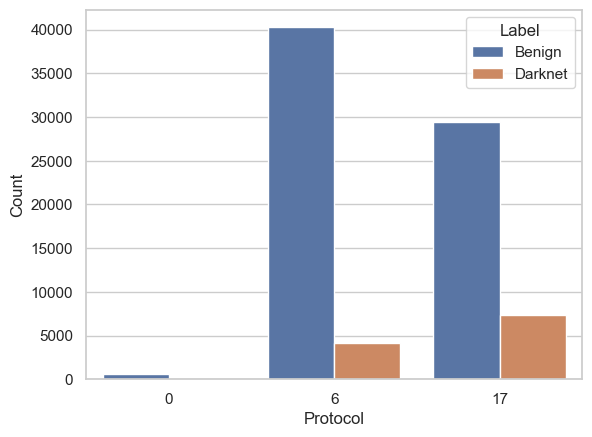

,count,mean,std,min,25%,50%,75%,max
Protocol,81879.0,10.891987,5.544165,0.0,6.0,6.0,17.0,17.0


In [36]:
cols = ['Protocol']
visualizer(outlier_removed_df, cols, 'count')

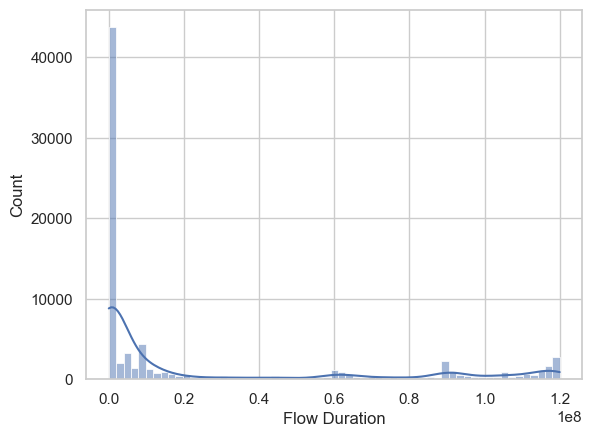

,count,mean,std,min,25%,50%,75%,max
Flow Duration,81879.0,2.591723e+07,4.067364e+07,355.0,325893.0,832876.0,43638588.5,119999999.0


In [37]:
cols = ['Flow Duration']
visualizer(outlier_removed_df, cols, 'hist')

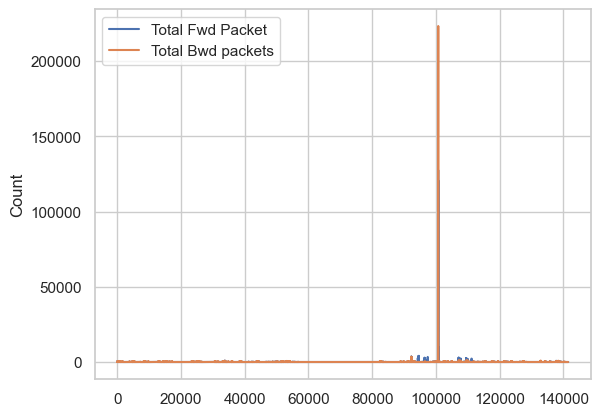

,count,mean,std,min,25%,50%,75%,max
Total Fwd Packet,81879.0,20.043002,785.145783,1.0,2.0,2.0,5.0,127618.0
Total Bwd packets,81879.0,13.985198,874.690280,0.0,0.0,1.0,4.0,223395.0


In [38]:
cols = ['Total Fwd Packet', 'Total Bwd packets']
visualizer(outlier_removed_df, cols, 'line_single')

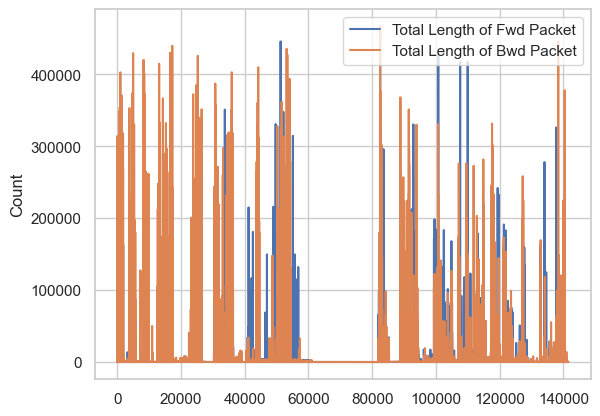

,count,mean,std,min,25%,50%,75%,max
Total Length of Fwd Packet,81879.0,1506.366919,11608.469066,0.0,32.0,60.0,406.0,459124.0
Total Length of Bwd Packet,81879.0,3487.939557,21599.034060,0.0,0.0,4.0,209.0,467281.0


In [39]:
cols = ['Total Length of Fwd Packet', 'Total Length of Bwd Packet']
visualizer(outlier_removed_df, cols, 'line_single')

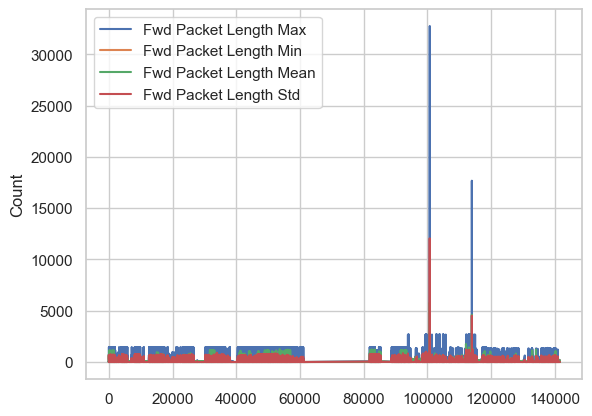

,count,mean,std,min,25%,50%,75%,max
Fwd Packet Length Max,81879.0,214.344301,429.064961,0.0,20.0,35.0,144.000000,32768.00000
Fwd Packet Length Min,81879.0,17.549653,31.414250,0.0,0.0,0.0,30.000000,1107.00000
Fwd Packet Length Mean,81879.0,60.917006,113.561467,0.0,18.0,29.0,50.000000,5798.30137
Fwd Packet Length Std,81879.0,70.515834,153.137728,0.0,0.0,0.0,51.960562,12059.60604


In [40]:
cols = ['Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std']
visualizer(outlier_removed_df, cols, 'line_single')

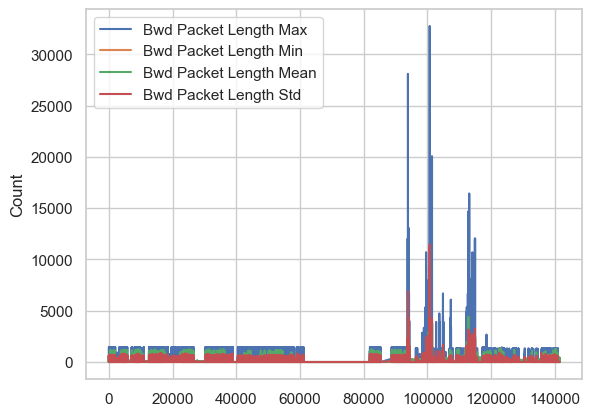

,count,mean,std,min,25%,50%,75%,max
Bwd Packet Length Max,81879.0,226.479158,572.538081,0.0,0.0,4.0,154.000000,32768.000000
Bwd Packet Length Min,81879.0,21.912542,59.644419,0.0,0.0,0.0,0.000000,1349.000000
Bwd Packet Length Mean,81879.0,87.008908,195.661796,0.0,0.0,2.0,57.788889,6473.490196
Bwd Packet Length Std,81879.0,77.762917,200.999498,0.0,0.0,0.0,19.052559,11469.193480


In [41]:
cols = ['Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std']
visualizer(outlier_removed_df, cols, 'line_single')

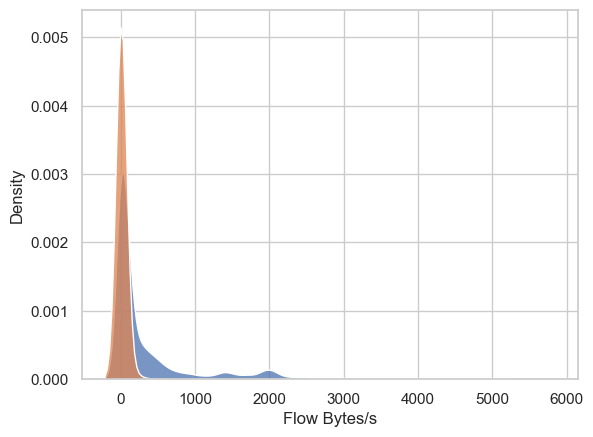

,count,mean,std,min,25%,50%,75%,max
Flow Bytes/s,81879.0,370.705563,675.725810,0.000000,4.477525,103.528437,353.125454,3915.824300
Flow Packets/s,81879.0,135.633375,689.565532,0.016669,0.354587,4.731801,10.439146,5633.802817


In [42]:
cols = ['Flow Bytes/s', 'Flow Packets/s']
visualizer(outlier_removed_df, cols, 'kde')

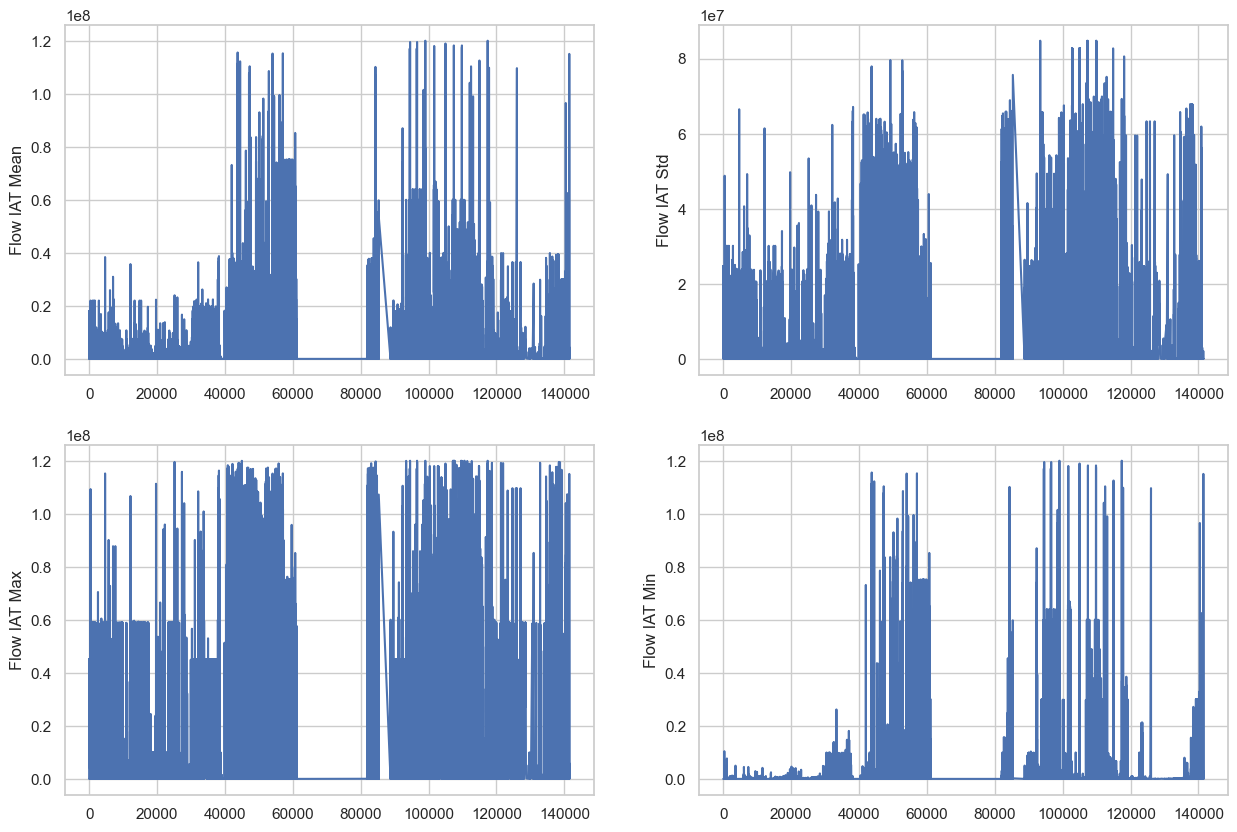

,count,mean,std,min,25%,50%,75%,max
Flow IAT Mean,81879.0,3.331782e+06,7.770250e+06,220.6,135455.0,414526.0000,3.200459e+06,1.199856e+08
Flow IAT Std,81879.0,4.129189e+06,8.456378e+06,0.0,0.0,217158.1804,3.720590e+06,8.477462e+07
Flow IAT Max,81879.0,1.238755e+07,2.091760e+07,355.0,305587.0,725286.0000,1.022824e+07,1.199994e+08
Flow IAT Min,81879.0,1.123549e+06,6.195423e+06,-394.0,18.0,375.0000,4.082300e+05,1.199856e+08


In [43]:
cols = ['Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min']
visualizer(outlier_removed_df, cols, 'line_multiple', (15, 10), (2, 2))

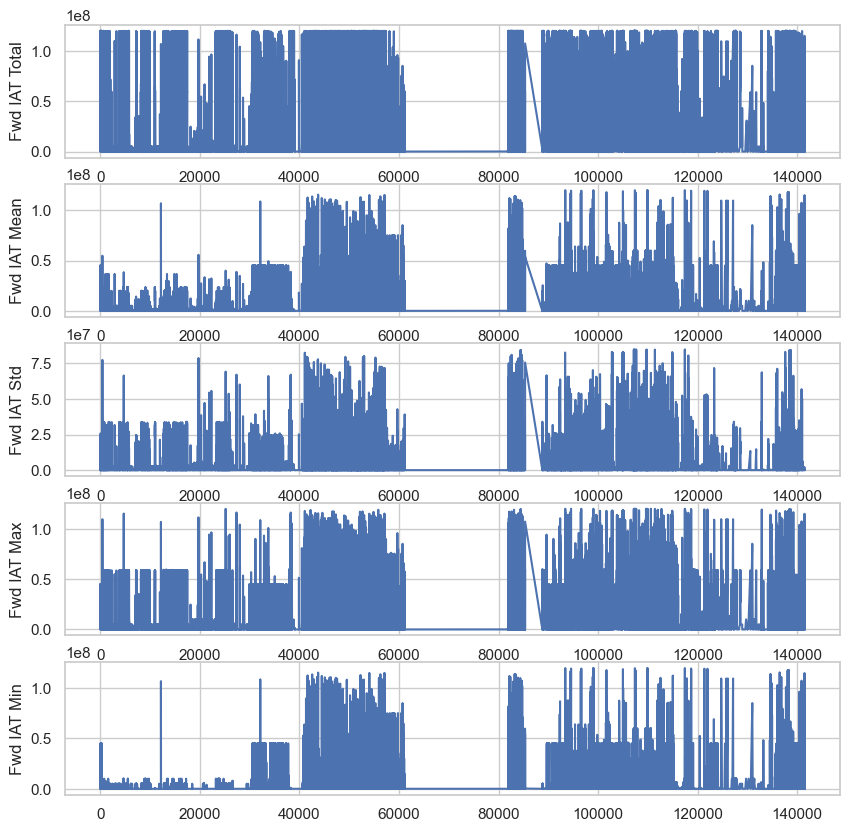

,count,mean,std,min,25%,50%,75%,max
Fwd IAT Total,81879.0,2.475694e+07,4.036737e+07,0.0,112.0,420984.0,3.614203e+07,1.200000e+08
Fwd IAT Mean,81879.0,5.383841e+06,1.271643e+07,0.0,112.0,411607.0,4.704023e+06,1.199997e+08
Fwd IAT Std,81879.0,3.242663e+06,7.717821e+06,0.0,0.0,0.0,2.310924e+06,8.483684e+07
Fwd IAT Max,81879.0,1.165886e+07,2.062344e+07,0.0,112.0,420838.0,1.002801e+07,1.199997e+08
Fwd IAT Min,81879.0,3.368927e+06,1.192236e+07,-350.0,20.0,194.0,4.112660e+05,1.199997e+08


In [44]:
cols = ['Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min']
visualizer(outlier_removed_df, cols, 'line_multiple', (10, 10), (5, 1))

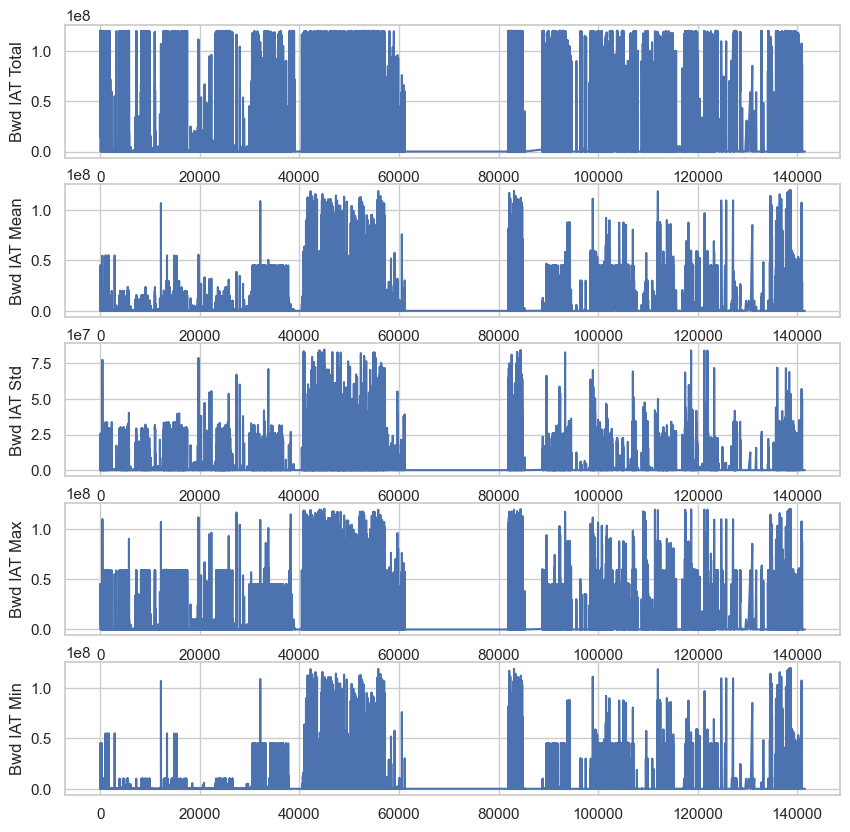

,count,mean,std,min,25%,50%,75%,max
Bwd IAT Total,81879.0,2.024249e+07,3.826900e+07,0.0,0.0,0.0,1.030655e+07,1.200000e+08
Bwd IAT Mean,81879.0,3.931873e+06,1.133977e+07,0.0,0.0,0.0,9.124226e+05,1.198065e+08
Bwd IAT Std,81879.0,2.711396e+06,7.197505e+06,0.0,0.0,0.0,4.879019e+05,8.480719e+07
Bwd IAT Max,81879.0,9.173071e+06,1.918669e+07,0.0,0.0,0.0,7.280516e+06,1.199657e+08
Bwd IAT Min,81879.0,2.148294e+06,1.015473e+07,-4.0,0.0,0.0,1.100000e+02,1.198065e+08


In [45]:
cols = ['Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min']
visualizer(outlier_removed_df, cols, 'line_multiple', (10, 10), (5, 1))

C:\Users\Bora\AppData\Local\Temp\ipykernel_40132\3750586348.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], multiple='stack')


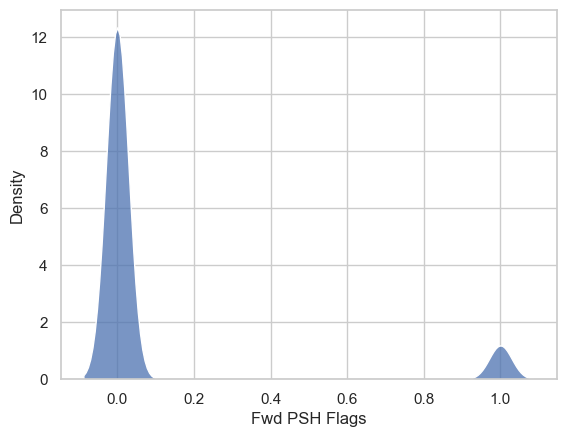

,count,mean,std,min,25%,50%,75%,max
Fwd PSH Flags,81879.0,0.087764,0.282953,0.0,0.0,0.0,0.0,1.0
Bwd PSH Flags,81879.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [46]:
cols = ['Fwd PSH Flags', 'Bwd PSH Flags']
visualizer(outlier_removed_df, cols, 'kde')

C:\Users\Bora\AppData\Local\Temp\ipykernel_40132\3750586348.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], multiple='stack')
C:\Users\Bora\AppData\Local\Temp\ipykernel_40132\3750586348.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], multiple='stack')


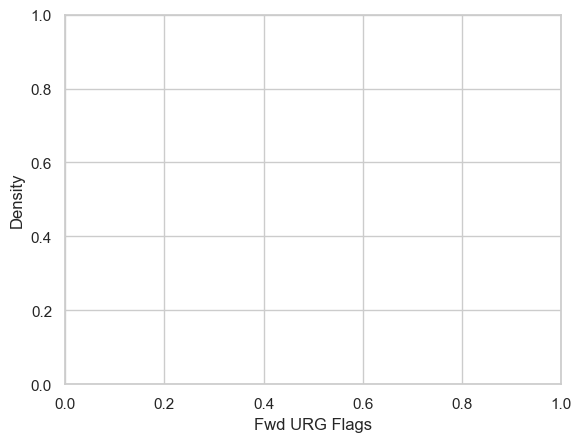

,count,mean,std,min,25%,50%,75%,max
Fwd URG Flags,81879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bwd URG Flags,81879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
cols = ['Fwd URG Flags', 'Bwd URG Flags']
visualizer(outlier_removed_df, cols, 'kde')

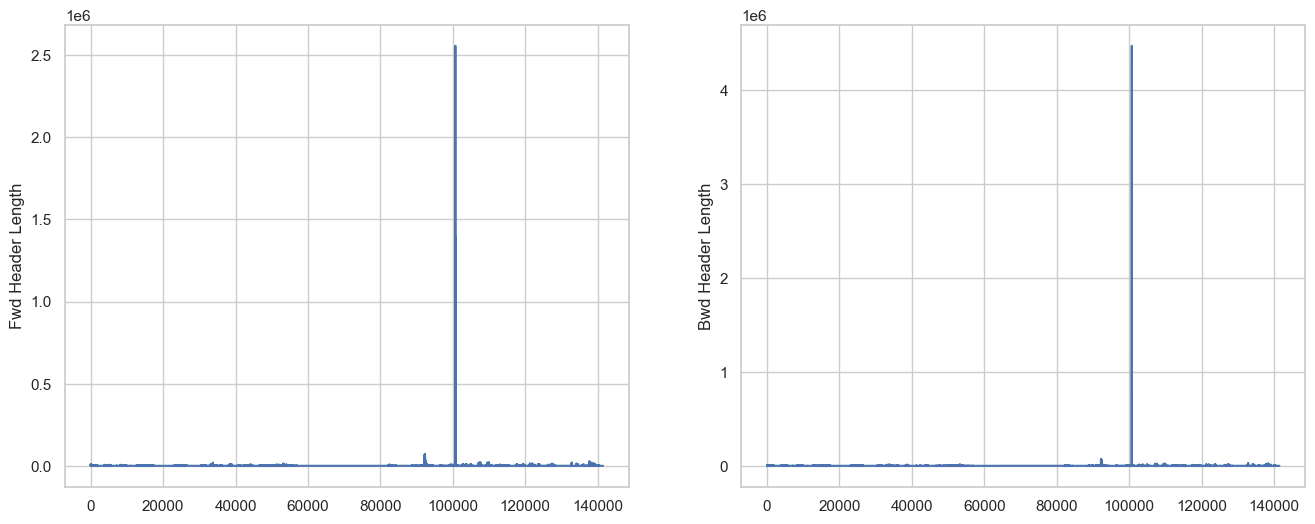

,count,mean,std,min,25%,50%,75%,max
Fwd Header Length,81879.0,353.323025,15119.330948,0.0,16.0,40.0,112.0,2556224.0
Bwd Header Length,81879.0,294.521428,17518.300885,0.0,0.0,16.0,92.0,4473804.0


In [48]:
cols = ['Fwd Header Length', 'Bwd Header Length']
visualizer(outlier_removed_df, cols, 'line_multiple', (16, 6), (1, 2))

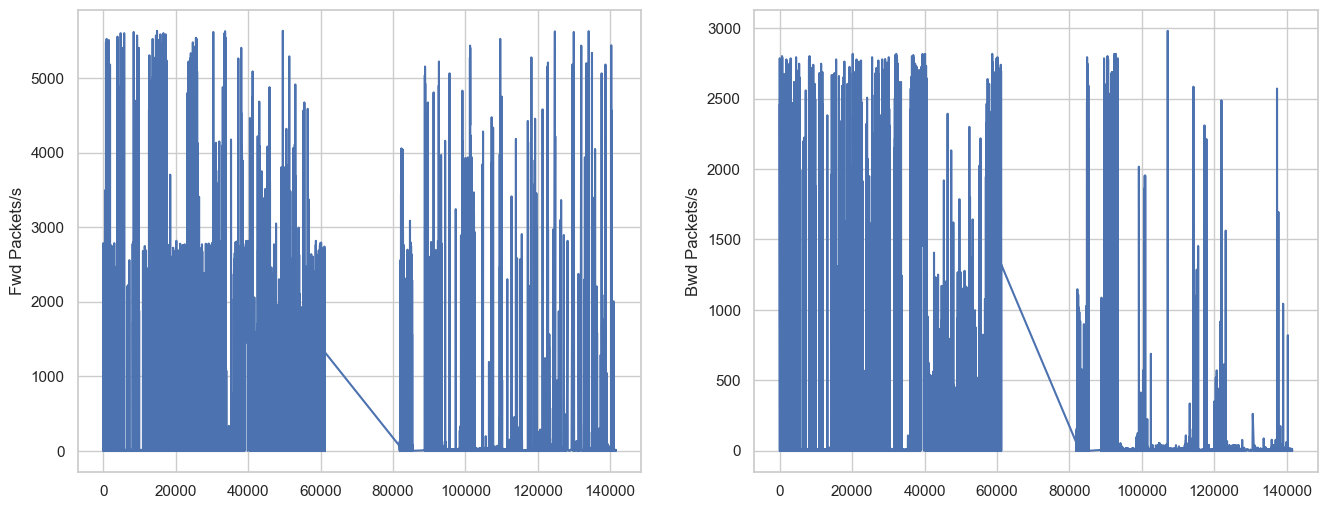

,count,mean,std,min,25%,50%,75%,max
Fwd Packets/s,81879.0,89.906621,473.049548,0.008417,0.306386,2.715985,5.809630,5633.802817
Bwd Packets/s,81879.0,45.726755,289.455458,0.000000,0.000000,0.185400,3.744736,2980.625931


In [49]:
cols = ['Fwd Packets/s', 'Bwd Packets/s']
visualizer(outlier_removed_df, cols, 'line_multiple', (16, 6), (1, 2))

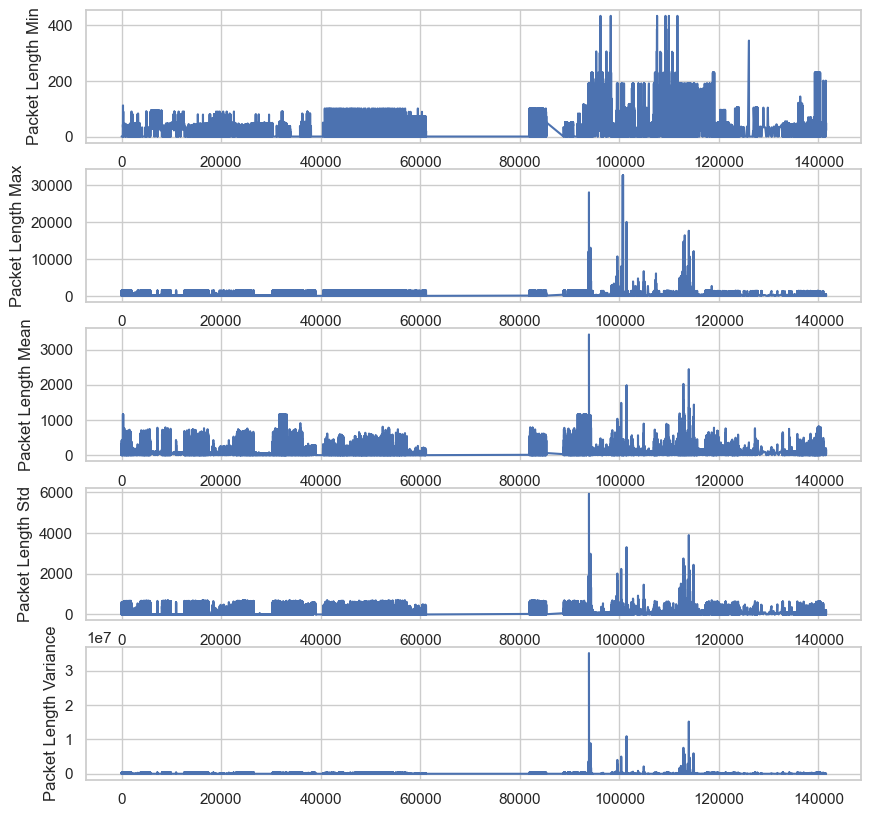

,count,mean,std,min,25%,50%,75%,max
Packet Length Min,81879.0,16.358199,25.691398,0.0,0.000000,0.000000,29.000000,4.340000e+02
Packet Length Max,81879.0,312.210335,639.327889,0.0,20.000000,53.000000,240.000000,3.276800e+04
Packet Length Mean,81879.0,78.189618,129.839768,0.0,11.333333,33.000000,90.514113,3.430845e+03
Packet Length Std,81879.0,99.647826,181.373442,0.0,0.000000,7.155418,106.809800,5.926146e+03
Packet Length Variance,81879.0,42825.612977,202002.002771,0.0,0.000000,51.200000,11408.333330,3.511921e+07


In [50]:
cols = ['Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance']
visualizer(outlier_removed_df, cols, 'line_multiple', (10, 10), (5, 1))

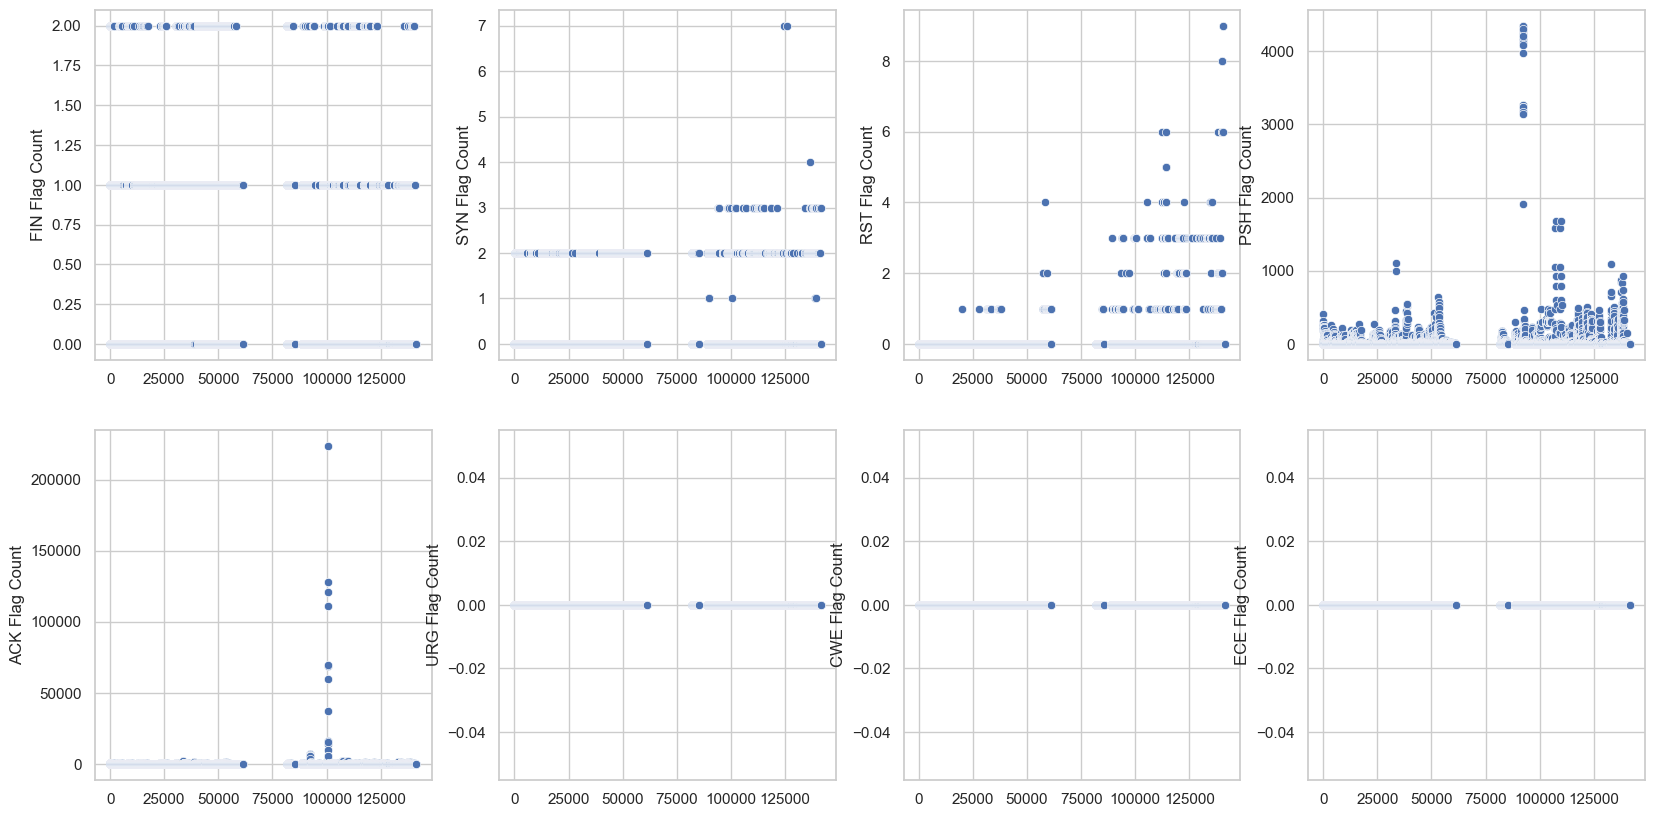

,count,mean,std,min,25%,50%,75%,max
FIN Flag Count,81879.0,0.403351,0.548341,0.0,0.0,0.0,1.0,2.0
SYN Flag Count,81879.0,0.515150,0.876737,0.0,0.0,0.0,2.0,7.0
RST Flag Count,81879.0,0.014314,0.184370,0.0,0.0,0.0,0.0,9.0
PSH Flag Count,81879.0,7.345119,81.195408,0.0,0.0,0.0,2.0,4350.0
ACK Flag Count,81879.0,28.780591,1160.777813,0.0,0.0,2.0,7.0,223897.0
URG Flag Count,81879.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
CWE Flag Count,81879.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ECE Flag Count,81879.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [51]:
cols = ['FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'CWE Flag Count',
 'ECE Flag Count']
visualizer(outlier_removed_df, cols, 'scatter_multiple', (20, 10), (2, 4))

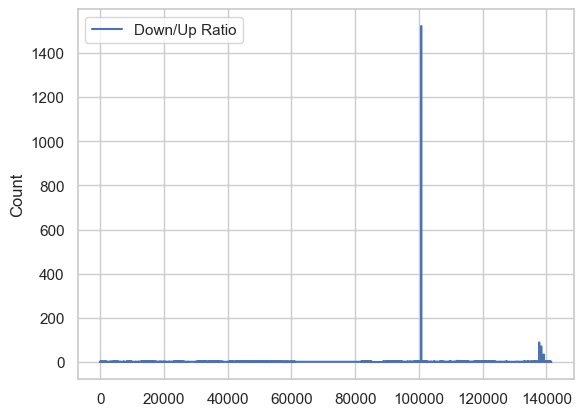

,count,mean,std,min,25%,50%,75%,max
Down/Up Ratio,81879.0,0.525287,5.585024,0.0,0.0,0.0,1.0,1522.0


In [52]:
cols = ['Down/Up Ratio']
visualizer(outlier_removed_df, cols, 'line_single')

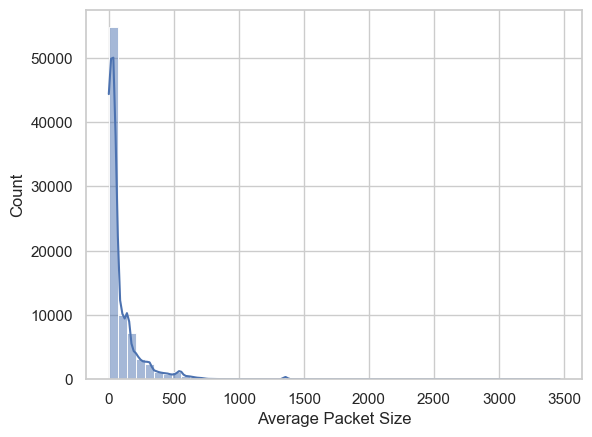

,count,mean,std,min,25%,50%,75%,max
Average Packet Size,81879.0,89.978226,138.742313,0.0,13.6,40.25,109.5,3466.583333


In [53]:
cols = ['Average Packet Size']
visualizer(outlier_removed_df, cols, 'hist', bins=50)

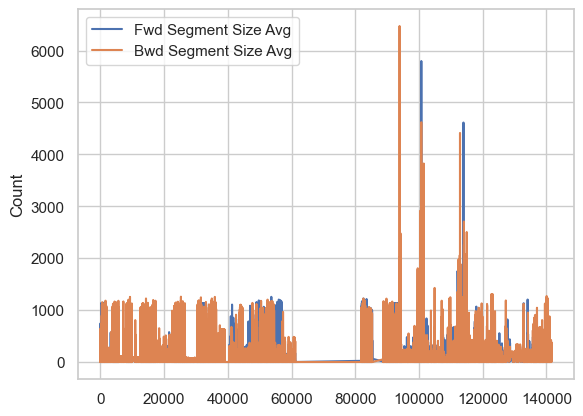

,count,mean,std,min,25%,50%,75%,max
Fwd Segment Size Avg,81879.0,60.917006,113.561467,0.0,18.0,29.0,50.000000,5798.301370
Bwd Segment Size Avg,81879.0,87.008908,195.661796,0.0,0.0,2.0,57.788889,6473.490196


In [54]:
cols = ['Fwd Segment Size Avg', 'Bwd Segment Size Avg']
visualizer(outlier_removed_df, cols, 'line_single')

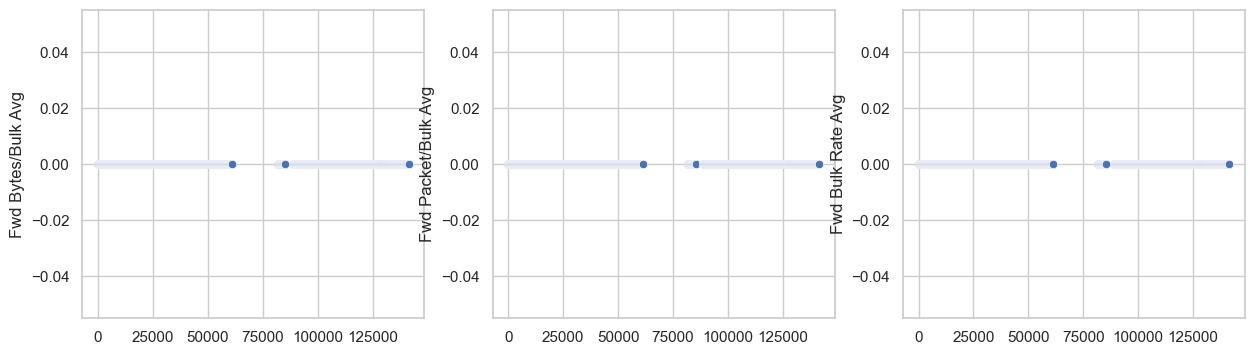

,count,mean,std,min,25%,50%,75%,max
Fwd Bytes/Bulk Avg,81879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fwd Packet/Bulk Avg,81879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fwd Bulk Rate Avg,81879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
cols = ['Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg']
visualizer(outlier_removed_df, cols, 'scatter_multiple', (15, 4), (1, 3))

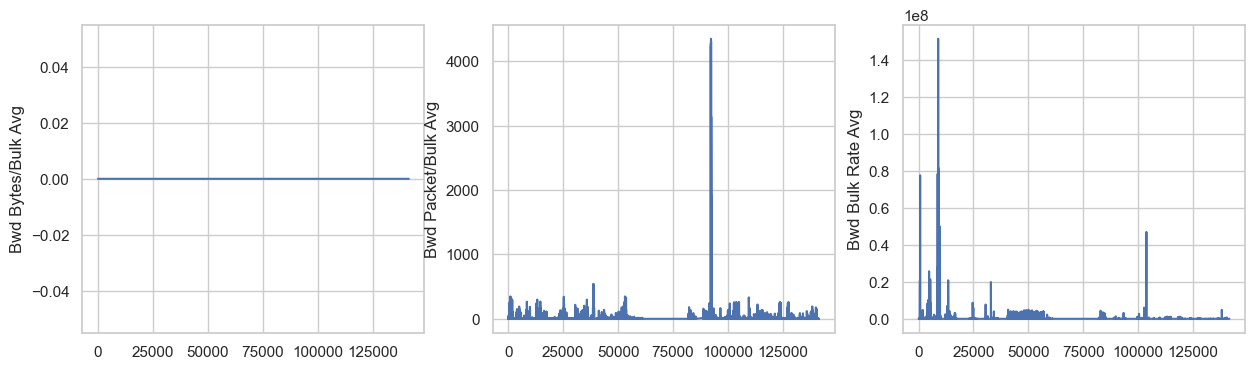

,count,mean,std,min,25%,50%,75%,max
Bwd Bytes/Bulk Avg,81879.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Bwd Packet/Bulk Avg,81879.0,4.598200,74.052802,0.0,0.0,0.0,4.0,4350.0
Bwd Bulk Rate Avg,81879.0,24836.908975,842944.947614,0.0,0.0,0.0,222.0,151574074.0


In [56]:
cols = ['Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg']
visualizer(outlier_removed_df, cols, 'line_multiple', (15, 4), (1, 3))

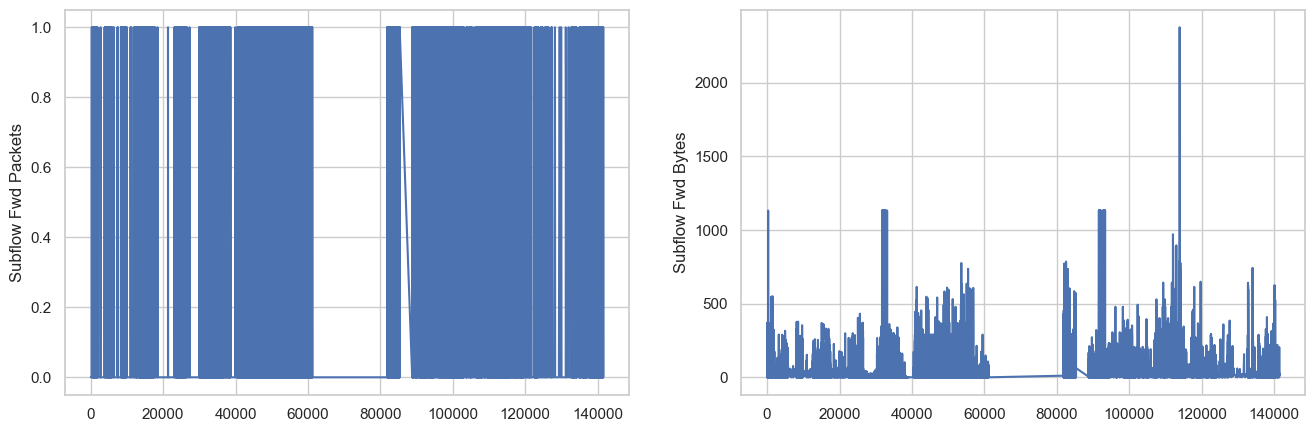

,count,mean,std,min,25%,50%,75%,max
Subflow Fwd Packets,81879.0,0.322708,0.467515,0.0,0.0,0.0,1.0,1.0
Subflow Fwd Bytes,81879.0,36.094005,75.171999,0.0,9.0,20.0,28.0,2376.0


In [57]:
cols = ['Subflow Fwd Packets', 'Subflow Fwd Bytes']
visualizer(outlier_removed_df, cols, 'line_multiple', (16, 5), (1, 2))

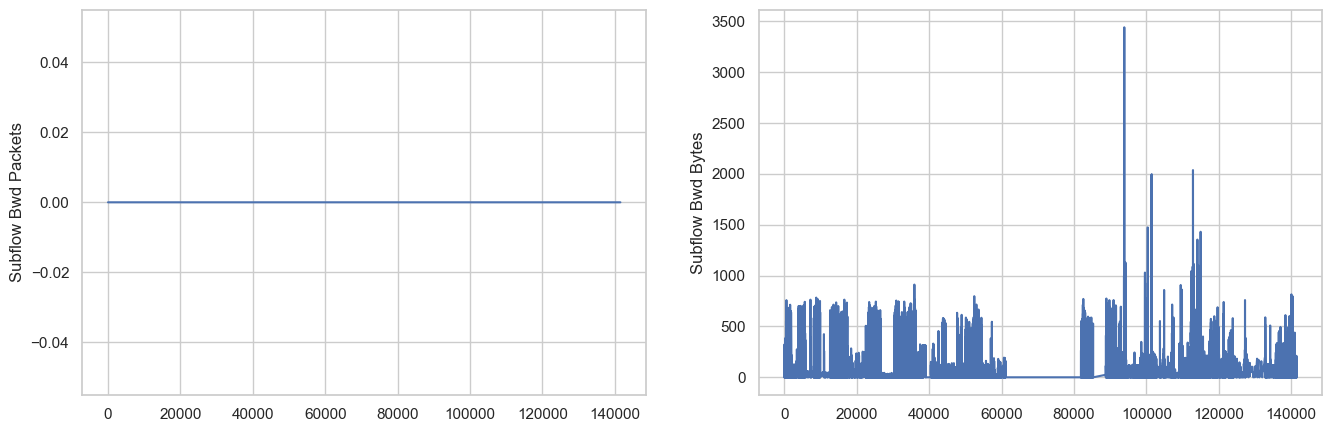

,count,mean,std,min,25%,50%,75%,max
Subflow Bwd Packets,81879.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Subflow Bwd Bytes,81879.0,43.681347,101.868087,0.0,0.0,0.0,28.0,3439.0


In [58]:
cols = ['Subflow Bwd Packets', 'Subflow Bwd Bytes']
visualizer(outlier_removed_df, cols, 'line_multiple', (16, 5), (1, 2))

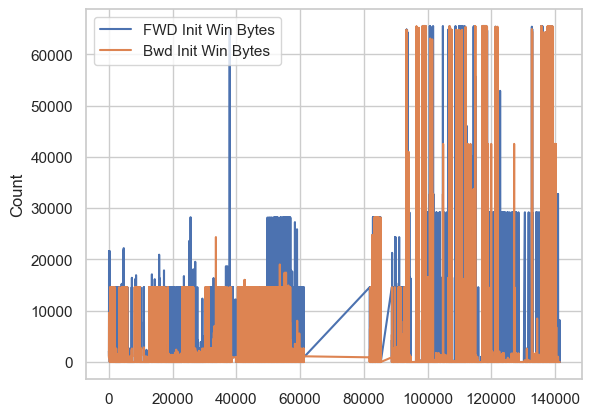

,count,mean,std,min,25%,50%,75%,max
FWD Init Win Bytes,81879.0,5271.641874,8876.168530,0.0,0.0,913.0,14600.0,65535.0
Bwd Init Win Bytes,81879.0,1583.224917,6768.333338,0.0,0.0,0.0,1047.0,65535.0


In [59]:
cols = ['FWD Init Win Bytes', 'Bwd Init Win Bytes']
visualizer(outlier_removed_df, cols, 'line_single')

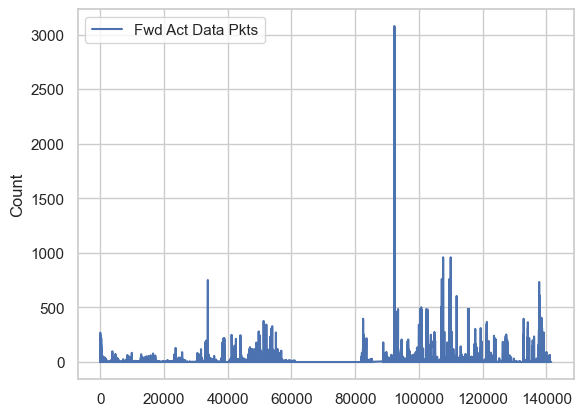

,count,mean,std,min,25%,50%,75%,max
Fwd Act Data Pkts,81879.0,5.109821,51.923117,0.0,0.0,1.0,2.0,3078.0


In [60]:
cols = ['Fwd Act Data Pkts']
visualizer(outlier_removed_df, cols, 'line_single')

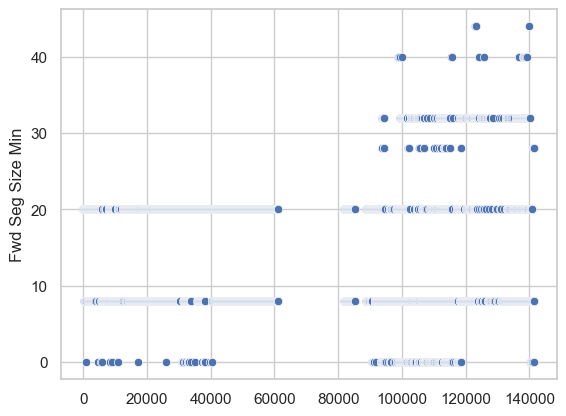

,count,mean,std,min,25%,50%,75%,max
Fwd Seg Size Min,81879.0,15.351629,7.579494,0.0,8.0,20.0,20.0,44.0


In [61]:
cols = ['Fwd Seg Size Min']
visualizer(outlier_removed_df, cols, 'scatter_single')

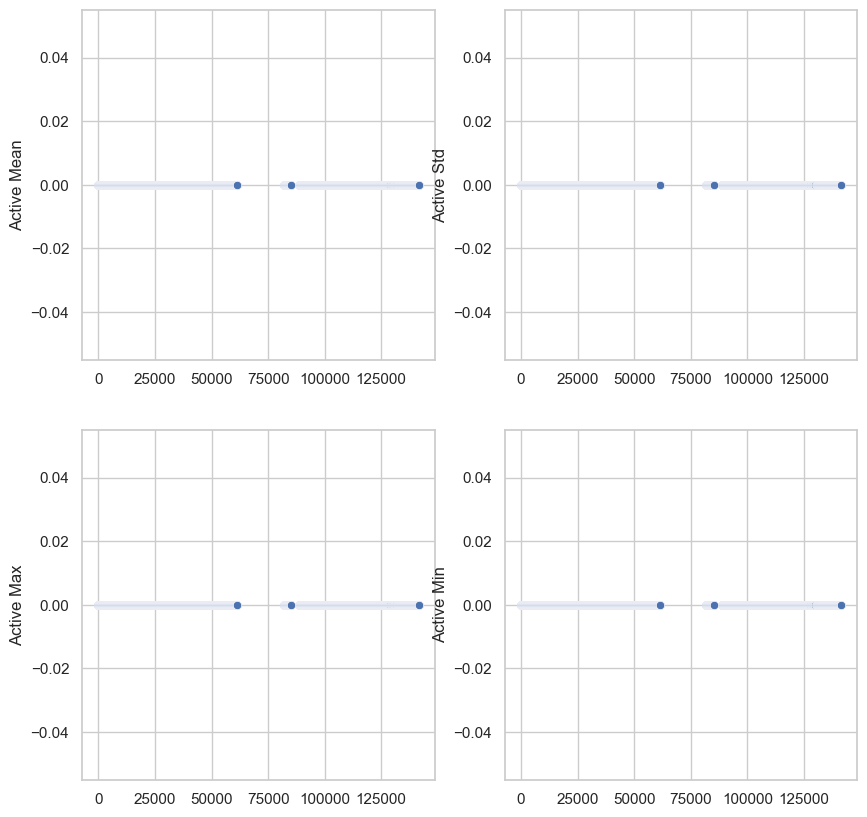

,count,mean,std,min,25%,50%,75%,max
Active Mean,81879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Active Std,81879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Active Max,81879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Active Min,81879.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
cols = ['Active Mean', 'Active Std', 'Active Max', 'Active Min']
visualizer(outlier_removed_df, cols, 'scatter_multiple', (10, 10), (2, 2))

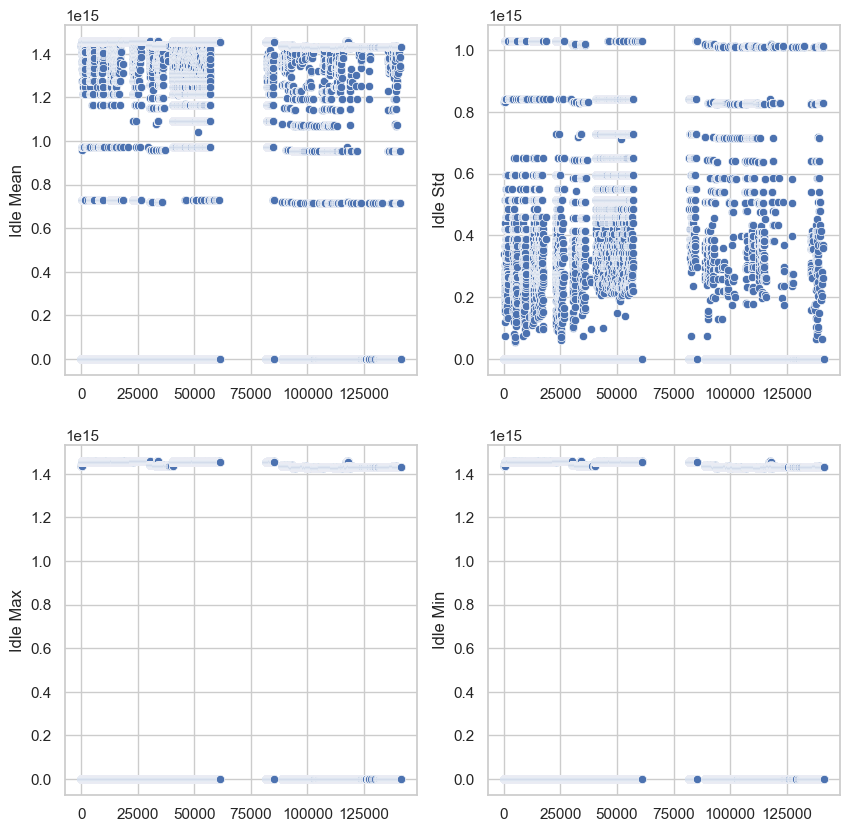

,count,mean,std,min,25%,50%,75%,max
Idle Mean,81879.0,8.226092e+14,6.917895e+14,0.0,0.0,1.365310e+15,1.456260e+15,1.460000e+15
Idle Std,81879.0,7.562634e+13,2.266418e+14,0.0,0.0,2.632855e+04,2.929866e+07,1.030000e+15
Idle Max,81879.0,8.619968e+14,7.111196e+14,0.0,0.0,1.432570e+15,1.456320e+15,1.460000e+15
Idle Min,81879.0,6.874832e+14,7.233469e+14,0.0,0.0,3.010340e+07,1.456260e+15,1.460000e+15


In [63]:
cols = ['Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']
visualizer(outlier_removed_df, cols, 'scatter_multiple', (10, 10), (2, 2))

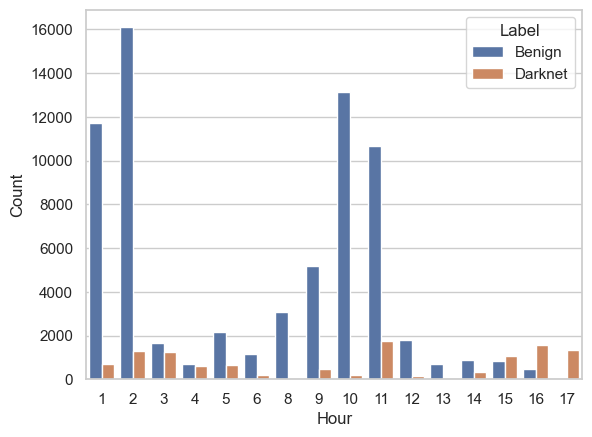

,count,mean,std,min,25%,50%,75%,max
Hour,81879.0,6.871469,4.756178,1.0,2.0,8.0,11.0,17.0


In [64]:
cols = ['Hour']
visualizer(outlier_removed_df, cols, 'count')

---

## 6- Modeller

Artık modele geçebiliriz. Önce bellekte yer etmesin diye halihazırda aktif olan bazı df değişkenlerini silelim.

In [65]:
del data, df, encoded_df, outlier_removed_df
df = normalized_df
del normalized_df

O kadar işlemin sonunda bile elimizde çok özellikli bir veri var. Bu özelliklerden bazıları sadece 0 gibi tekil değerlerden oluşmakla beraber bazıları da tahmin aşamamızda bize faydadan çok zarar getirecek özellikler olabilir. Bu yüzden tahmin etmek istediğimiz özellik ile en çok ilişkili olanları seçip test amaçlı ayrı bir veri oluşturacağız. Bunu yapmak için de *mutual_info_classif* fonksiyonunu kullanacağız. Bu fonksiyon diğer özelliklerin hedef özellikle arasındaki ilişkiyi ölçmeye yarayan bir fonksiyon.

In [66]:
y = df['Label']
X = df.drop(columns=['Label'])

mi = mutual_info_classif(X, y, random_state=42)

mi = pd.Series(mi, index=X.columns)
mi = mi.sort_values(ascending=False)

mi

Packet Length Max             0.191913
Idle Max                      0.186274
Packet Length Mean            0.183174
Idle Mean                     0.179966
Packet Length Std             0.179620
Packet Length Variance        0.177930
Average Packet Size           0.177800
Bwd Packet Length Max         0.174908
Flow IAT Max                  0.174556
Bwd Packet Length Mean        0.167586
Bwd Segment Size Avg          0.167404
Flow Duration                 0.167115
Idle Min                      0.165089
Flow IAT Min                  0.158843
Bwd Packet Length Min         0.157457
Total Length of Bwd Packet    0.152826
Fwd Header Length             0.142464
Total Length of Fwd Packet    0.142440
Fwd IAT Max                   0.134207
Flow Packets/s                0.128556
Bwd Header Length             0.127820
Fwd Packets/s                 0.126610
Subflow Bwd Bytes             0.126129
Bwd Packets/s                 0.121948
Flow IAT Mean                 0.120938
Hour                     

Hiçbir özellik hedef ile inanılmaz ilişkili görünmüyor. Öte yandan bazıları neredeyse ilişkisiz olarak nitelendirildiği için bunları kullanmamak faydamıza olabilir. Normalde 0.5 gibi bir eşik belirleyip 0.5-1.0 arasını alacağımızı varsayarsak bu özellikler için 0.1 gibi bir eşik belirlemek pek de yanlış olmayacaktır. 

In [67]:
features = mi[mi > 0.1].index
features

Index(['Packet Length Max', 'Idle Max', 'Packet Length Mean', 'Idle Mean',
       'Packet Length Std', 'Packet Length Variance', 'Average Packet Size',
       'Bwd Packet Length Max', 'Flow IAT Max', 'Bwd Packet Length Mean',
       'Bwd Segment Size Avg', 'Flow Duration', 'Idle Min', 'Flow IAT Min',
       'Bwd Packet Length Min', 'Total Length of Bwd Packet',
       'Fwd Header Length', 'Total Length of Fwd Packet', 'Fwd IAT Max',
       'Flow Packets/s', 'Bwd Header Length', 'Fwd Packets/s',
       'Subflow Bwd Bytes', 'Bwd Packets/s', 'Flow IAT Mean', 'Hour',
       'FWD Init Win Bytes', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Min',
       'Flow Bytes/s', 'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Segment Size Avg'],
      dtype='object')

In [68]:
features.size

34

Elimizde 34 özellik kalıyor. Hem varyanstan çok kaybetmemiş oluyoruz hem de elimizdeki veriyi bir miktar trimlemiş oluyoruz. 

In [69]:
df.head()

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Hour
1,-0.882372,-0.637194,-0.024254,-0.014846,-0.129765,-0.161487,-0.499564,-0.558656,-0.536426,-0.460476,-0.395573,-0.367389,-0.444693,-0.386884,-0.548607,6.929582,-0.428737,-0.488296,-0.592191,-0.181287,-0.613295,-0.423379,-0.420155,-0.565324,-0.282574,-0.528956,-0.346735,-0.376716,-0.478098,-0.211557,-0.310173,0.0,0.0,0.0,-0.022046,-0.015671,5.003937,8.330437,-0.636723,-0.488344,-0.602205,-0.549410,-0.212007,2.911797,-0.587581,-0.077637,-0.090463,-0.023071,0.0,0.0,0.0,0.084998,-0.648532,-0.536426,-0.444693,0.0,0.0,0.0,0.0,-0.062094,-0.029465,-0.690266,-0.480155,0.0,-0.428806,-0.370054,-0.079226,-0.098412,0.613286,0.0,0.0,0.0,0.0,-1.189111,-0.333684,-1.212176,-0.950426,0,-0.603738
2,-0.882372,-0.637193,-0.024254,-0.014846,-0.129765,-0.161487,-0.499564,-0.558656,-0.536426,-0.460476,-0.395573,-0.367389,-0.444693,-0.386884,-0.548607,6.532759,-0.428734,-0.488296,-0.592190,-0.181283,-0.613295,-0.423379,-0.420155,-0.565324,-0.282574,-0.528956,-0.346735,-0.376716,-0.478098,-0.211557,-0.310173,0.0,0.0,0.0,-0.022046,-0.015671,4.714712,7.857764,-0.636723,-0.488344,-0.602205,-0.549410,-0.212007,2.911797,-0.587581,-0.077637,-0.090463,-0.023071,0.0,0.0,0.0,0.084998,-0.648532,-0.536426,-0.444693,0.0,0.0,0.0,0.0,-0.062094,-0.029465,-0.690266,-0.480155,0.0,-0.428806,-0.363069,-0.079226,-0.098412,0.613286,0.0,0.0,0.0,0.0,-1.189111,-0.333684,-1.212176,-0.950426,0,-0.603738
3,-0.882372,-0.637195,-0.024254,-0.014846,-0.129765,-0.161487,-0.499564,-0.558656,-0.536426,-0.460476,-0.395573,-0.367389,-0.444693,-0.386884,-0.548607,7.882399,-0.428743,-0.488296,-0.592193,-0.181295,-0.613295,-0.423379,-0.420155,-0.565324,-0.282574,-0.528956,-0.346735,-0.376716,-0.478098,-0.211557,-0.310173,0.0,0.0,0.0,-0.022046,-0.015671,5.698399,9.465378,-0.636723,-0.488344,-0.602205,-0.549410,-0.212007,2.911797,-0.587581,-0.077637,-0.090463,-0.023071,0.0,0.0,0.0,0.084998,-0.648532,-0.536426,-0.444693,0.0,0.0,0.0,0.0,-0.062094,-0.029465,-0.690266,-0.480155,0.0,-0.428806,-0.367688,-0.079226,-0.098412,0.613286,0.0,0.0,0.0,0.0,-1.189111,-0.333684,-1.212176,-0.950426,0,-0.603738
5,-0.882372,-0.626844,-0.019160,-0.012559,-0.123563,-0.157829,-0.331757,-0.558656,-0.409622,-0.250211,-0.257590,-0.367389,-0.310106,-0.159963,-0.018268,-0.169162,-0.421043,-0.469696,-0.572281,-0.181350,-0.602857,-0.415096,-0.393229,-0.545102,-0.282558,-0.518035,-0.328307,-0.335866,-0.456371,-0.211451,-0.310173,0.0,0.0,0.0,-0.015961,-0.012702,-0.164974,-0.133379,-0.636723,-0.364776,-0.472985,-0.365599,-0.206505,1.088104,1.693620,-0.077637,-0.065831,-0.018764,0.0,0.0,0.0,-0.094053,-0.512487,-0.409622,-0.310106,0.0,0.0,0.0,0.0,-0.062094,-0.029465,-0.690266,-0.360429,0.0,-0.340456,1.050951,-0.099024,-0.079153,0.613286,0.0,0.0,0.0,0.0,0.889237,-0.333684,0.809676,1.03

In [70]:
df_mi = df[features].copy()
df_mi['Label'] = df['Label']

df_mi.head()

,Packet Length Max,Idle Max,Packet Length Mean,Idle Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Bwd Packet Length Max,Flow IAT Max,Bwd Packet Length Mean,Bwd Segment Size Avg,Flow Duration,Idle Min,Flow IAT Min,Bwd Packet Length Min,Total Length of Bwd Packet,Fwd Header Length,Total Length of Fwd Packet,Fwd IAT Max,Flow Packets/s,Bwd Header Length,Fwd Packets/s,Subflow Bwd Bytes,Bwd Packets/s,Flow IAT Mean,Hour,FWD Init Win Bytes,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Min,Flow Bytes/s,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Segment Size Avg,Label
1,-0.488344,-1.212176,-0.602205,-1.189111,-0.549410,-0.212007,-0.648532,-0.395573,-0.592191,-0.444693,-0.444693,-0.637194,-0.950426,-0.181287,-0.367389,-0.161487,-0.022046,-0.129765,-0.565324,6.929582,-0.015671,5.003937,-0.428806,8.330437,-0.428737,-0.603738,-0.370054,-0.613295,-0.423379,-0.282574,-0.548607,-0.499564,-0.536426,-0.536426,0
2,-0.488344,-1.212176,-0.602205,-1.189111,-0.549410,-0.212007,-0.648532,-0.395573,-0.592190,-0.444693,-0.444693,-0.637193,-0.950426,-0.181283,-0.367389,-0.161487,-0.022046,-0.129765,-0.565324,6.532759,-0.015671,4.714712,-0.428806,7.857764,-0.428734,-0.603738,-0.363069,-0.613295,-0.423379,-0.282574,-0.548607,-0.499564,-0.536426,-0.536426,0
3,-0.488344,-1.212176,-0.602205,-1.189111,-0.549410,-0.212007,-0.648532,-0.395573,-0.592193,-0.444693,-0.444693,-0.637195,-0.950426,-0.181295,-0.367389,-0.161487,-0.022046,-0.129765,-0.565324,7.882399,-0.015671,5.698399,-0.428806,9.465378,-0.428743,-0.603738,-0.367688,-0.613295,-0.423379,-0.282574,-0.548607,-0.499564,-0.536426,-0.536426,0
5,-0.364776,0.809676,-0.472985,0.889237,-0.365599,-0.206505,-0.512487,-0.257590,-0.572281,-0.310106,-0.310106,-0.626844,1.037250,-0.181350,-0.367389,-0.157829,-0.015961,-0.123563,-0.545102,-0.169162,-0.012702,-0.164974,-0.340456,-0.133379,-0.421043,-0.603738,1.050951,-0.602857,-0.415096,-0.282558,-0.018268,-0.331757,-0.409622,-0.409622,0
6,1.795318,0.809676,2.580837,0.889237,2.603369,1.406730,2.333321,2.154491,0.052490,2.851727,2.851727,2.305313,1.037236,-0.181352,-0.367389,14.381150,0.622166,7.559409,0.088572,-0.184881,0.539181,-0.181439,2.732164,-0.143918,-0.412976,-0.603738,0.770197,2.350573,-0.404060,-0.282573,4.439090,2.903204,1.074233,1.074233,0


Şimdi bu iki veri üzerinde farklı modelleri deneyip en iyi sonucu hangisinin vereceğine bakacağız. Öncelikle veriyi train ve test olarak ayırmamız gerekiyor.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Label', axis=1),
    df['Label'],
    test_size=.2,
    random_state=42,
    shuffle=True
)

X_train_mi, X_test_mi, y_train_mi, y_test_mi = train_test_split(
    df_mi.drop('Label', axis=1),
    df_mi['Label'],
    test_size=.2,
    random_state=42,
    shuffle=True
)

Deneyeceğimiz modeller sırasıyla KNN Classifier, Random Forest Classifier, SVM Classifier, MLP Classifier ve XGBoost Classifier olacak. Bu modellerin parametrelerini elimizden geldiğince fine-tune etmek için de GridSearchCV kullanacağız.

Öncelikle model çalıştırma, fine-tune etme ve değerlendirme için birkaç fonksiyon ve parametreler için hazır bir map yazıyoruz. Böylece her seferinde aynı işlemleri tekrar tekrar yapmaktansa yazmış olduğumuz fonksiyonu çağırabileceğiz.

In [72]:
param_spaces = {
    'XGBClassifier': {
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7, 1.0],
        'colsample_bytree': [0.5, 0.7, 1.0],
        'n_estimators' : [100, 200, 500],
        'objective': ['binary:logistic']
    },

    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },

    'GradientBoostingClassifier': {
        'loss': ['log_loss', 'exponential'],
        'learning_rate': [0.1, 0.01, 0.001],
        'n_estimators': [100, 200, 300, 400, 500],
        'min_samples_split': [2, 4, 6, 8],
        'max_depth': [3, 5, 7]
    },
}

In [73]:
def param_finder(model, X_train, y_train):
    param_space = param_spaces[model.__class__.__name__]
    model = globals()[model.__class__.__name__](random_state=42)

    bayes_search = BayesSearchCV(
        model, 
        param_space, 
        n_jobs=-1, 
        cv=5, 
        n_iter=20, 
        random_state=42
    )
    
    bayes_search.fit(X_train, y_train)

    return bayes_search.best_params_


def metric_eval(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {round((accuracy * 100.0), 5)}%")
    print(f"Precision: {round((precision * 100.0), 5)}%")
    print(f"Recall: {round((recall * 100.0), 5)}%")
    print(f"ROC AUC: {round((roc_auc * 100.0), 5)}%")


def model_eval(model, X_train, X_test, y_train, y_test):
    params = param_finder(model, X_train, y_train)

    print(f"{model.__class__.__name__} için en iyi parametreler:")
    print(params)
    print()

    model = globals()[model.__class__.__name__](random_state=42, **params)
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metric_eval(y_test, y_pred)

### KNN Classifier

Bu model diğerlerine göre biraz daha basit olduğu için fine-tune etmekle uğraşmak yerine sadece optimal k değerini seçeceğiz.

In [74]:
scores = []
scores_mi = []

for i in range(1, 11):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train, y_train)
    scores.append(f"{i} için score: {round(knn.score(X_test, y_test), 5)}")
    knn.fit(X_train_mi, y_train_mi)
    scores_mi.append(f"{i} için score: {round(knn.score(X_test_mi, y_test_mi), 5)}")

In [75]:
for i in range(len(scores)):
    print(scores[i] + "\t\t" + scores_mi[i])

1 için score: 0.9757		1 için score: 0.97099
2 için score: 0.97576		2 için score: 0.97057
3 için score: 0.97557		3 için score: 0.96953
4 için score: 0.97454		4 için score: 0.9691
5 için score: 0.9724		5 için score: 0.96733
6 için score: 0.97185		6 için score: 0.96623
7 için score: 0.97051		7 için score: 0.96599
8 için score: 0.96989		8 için score: 0.96513
9 için score: 0.96947		9 için score: 0.96519
10 için score: 0.96886		10 için score: 0.96379


İki veri için de 3 iyi bir değer gibi duruyor. En yüksek skoru 2 değeri için alıyor olsak da bu algoritma için çift sayı seçmek mantıklı olmadığı için 3 değerini seçiyoruz.

In [76]:
knn = KNeighborsClassifier(3)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

knn.fit(X_train_mi, y_train_mi)
y_pred_mi = knn.predict(X_test_mi)

print("Normal veri seti:")
print(f"Accuracy: {round((accuracy_score(y_test, y_pred) * 100.0), 5)}%")
print(f"Precision: {round((precision_score(y_test, y_pred) * 100.0), 5)}%")
print(f"Recall: {round((recall_score(y_test, y_pred) * 100.0), 5)}%")
print(f"ROC AUC: {round((roc_auc_score(y_test, y_pred) * 100.0), 5)}%")

print()

print("MI veri seti:")
print(f"Accuracy: {round((accuracy_score(y_test_mi, y_pred_mi) * 100.0), 5)}%")
print(f"Precision: {round((precision_score(y_test_mi, y_pred_mi) * 100.0), 5)}%")
print(f"Recall: {round((recall_score(y_test_mi, y_pred_mi) * 100.0), 5)}%")
print(f"ROC AUC: {round((roc_auc_score(y_test_mi, y_pred_mi) * 100.0), 5)}%")

Normal veri seti:
Accuracy: 97.5574%
Precision: 93.69766%
Recall: 89.21527%
ROC AUC: 94.09667%

MI veri seti:
Accuracy: 96.95286%
Precision: 91.86667%
Recall: 86.7394%
ROC AUC: 92.7158%


---

### XGB Classifier

In [77]:
%%time

model_eval(XGBClassifier(), X_train, X_test, y_train, y_test)

XGBClassifier için en iyi parametreler:
OrderedDict({'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'subsample': 1.0})

Accuracy: 98.71153%
Precision: 98.39572%
Recall: 92.65632%
ROC AUC: 96.19952%
CPU times: total: 1min 37s
Wall time: 3min 12s


In [78]:
%%time

model_eval(XGBClassifier(), X_train_mi, X_test_mi, y_train_mi, y_test_mi)

XGBClassifier için en iyi parametreler:
OrderedDict({'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 1.0})

Accuracy: 98.65657%
Precision: 98.00266%
Recall: 92.65632%
ROC AUC: 96.16736%
CPU times: total: 40.8 s
Wall time: 1min 46s


---

### Random Forest Classifier

In [79]:
%%time

model_eval(RandomForestClassifier(), X_train, X_test, y_train, y_test)

RandomForestClassifier için en iyi parametreler:
OrderedDict({'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500})

Accuracy: 98.56497%
Precision: 97.94643%
Recall: 92.06882%
ROC AUC: 95.87004%
CPU times: total: 2min 59s
Wall time: 24min 37s


In [80]:
%%time

model_eval(RandomForestClassifier(), X_train_mi, X_test_mi, y_train_mi, y_test_mi)

RandomForestClassifier için en iyi parametreler:
OrderedDict({'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500})

Accuracy: 98.55887%
Precision: 97.94551%
Recall: 92.02686%
ROC AUC: 95.84906%
CPU times: total: 1min 42s
Wall time: 18min 23s


---

### GradientBoostingClassifier

In [81]:
%%time

model_eval(GradientBoostingClassifier(), X_train, X_test, y_train, y_test)

GradientBoostingClassifier için en iyi parametreler:
OrderedDict({'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 300})

Accuracy: 98.66878%
Precision: 98.04705%
Recall: 92.69828%
ROC AUC: 96.19192%
CPU times: total: 9min 16s
Wall time: 1h 34min 7s


In [82]:
%%time

model_eval(GradientBoostingClassifier(), X_train_mi, X_test_mi, y_train_mi, y_test_mi)

GradientBoostingClassifier için en iyi parametreler:
OrderedDict({'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5, 'min_samples_split': 6, 'n_estimators': 400})

Accuracy: 98.58329%
Precision: 98.16391%
Recall: 91.98489%
ROC AUC: 95.84594%
CPU times: total: 5min 47s
Wall time: 55min 9s


---

Sonuçları incelediğimizde XGBoost Classifier modelinin elimizdeki veri için en uygun model olduğuna kanaat getirebiliriz. Hem isabetlilik hem de çalışma süresi açısından denediğimiz diğer modellere fark atıyor. İki veri arasından kıyaslama yaptığımızda da *mutual_info_classif* fonskiyonu kullanarak filtrelediğimiz veri bize performans olarak gözle görülür bir kayıp getirmezken model çalışma süresini epeyce kısaltabiliyor.

## Referanslar
[0] Veri seti: Arash Habibi Lashkari, Gurdip Kaur, and Abir Rahali, “DIDarknet: A Contemporary Approach to Detect and Characterize the Darknet Traffic using Deep Image Learning”, 10th International Conference on Communication and Network Security, Tokyo, Japan, November 2020.

[1], [2] https://www.unb.ca/cic/datasets/darknet2020.html (Nisan 2024'te erişilmiştir.)

[3] D’hooge, L., Verkerken, M., Volckaert, B., Wauters, T., De Turck, F. (2022). Establishing the Contaminating Effect of Metadata Feature Inclusion in Machine-Learned Network Intrusion Detection Models. In: Cavallaro, L., Gruss, D., Pellegrino, G., Giacinto, G. (eds) Detection of Intrusions and Malware, and Vulnerability Assessment. DIMVA 2022. Lecture Notes in Computer Science, vol 13358. Springer, Cham. https://doi.org/10.1007/978-3-031-09484-2_2